In [15]:
import pickle

In [16]:
import random

In [17]:
from time import time

In [18]:
from typing import Union

In [19]:
import numpy as np

In [28]:
import torch

In [29]:
from torch import nn, optim

In [30]:
from torch.nn import functional as F

In [31]:
from torch.nn.functional import mse_loss, l1_loss, binary_cross_entropy, cross_entropy

In [32]:
from torch.optim import Optimizer

In [33]:
import matplotlib.pyplot as plt

In [34]:
class NBeatsNet(nn.Module):
    SEASONALITY_BLOCK= 'seasonality'
    TREND_BLOCK= 'trend'
    GENERIC_BLOCK= 'generic'
    
    def __init__(self,
                device=torch.device('cpu'),
                stack_types=(TREND_BLOCK, SEASONALITY_BLOCK, GENERIC_BLOCK),
                nb_blocks_per_stack=3,
                forecast_length=24,
                backcast_length=288,
                thetas_dim=(2,24,3),
                share_weights_in_stack=False,
                hidden_layer_units=512,
                nb_harmonics=None):
        super(NBeatsNet, self).__init__()
        self.forecast_length = forecast_length
        self.backcast_length = backcast_length
        self.hidden_layer_units = hidden_layer_units
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.share_weights_in_stack = share_weights_in_stack
        self.nb_harmonics = nb_harmonics
        self.stack_types = stack_types
        self.stacks = []
        self.thetas_dim = thetas_dim
        self.parameters = []
        self.device = device
        print('| N-Beats')
        for stack_id in range(len(self.stack_types)):
            self.stacks.append(self.create_stack(stack_id))
        self.parameters = nn.ParameterList(self.parameters)
        self.to(self.device)
        self._loss = None
        self._opt = None

    def create_stack(self, stack_id):
        stack_type = self.stack_types[stack_id]
        print(f'| --  Stack {stack_type.title()} (#{stack_id}) (share_weights_in_stack={self.share_weights_in_stack})')
        blocks = []
        for block_id in range(self.nb_blocks_per_stack):
            block_init = NBeatsNet.select_block(stack_type)
            if self.share_weights_in_stack and block_id != 0:
                block = blocks[-1]  # pick up the last one when we share weights.
            else:
                block = block_init(self.hidden_layer_units, self.thetas_dim[stack_id],
                                   self.device, self.backcast_length, self.forecast_length, self.nb_harmonics)
                self.parameters.extend(block.parameters())
            print(f'     | -- {block}')
            blocks.append(block)
        return blocks

    def save(self, filename: str):
        torch.save(self, filename)

    @staticmethod
    def load(f, map_location=None, pickle_module=pickle, **pickle_load_args):
        return torch.load(f, map_location, pickle_module, **pickle_load_args)

    @staticmethod
    def select_block(block_type):
        if block_type == NBeatsNet.SEASONALITY_BLOCK:
            return SeasonalityBlock
        elif block_type == NBeatsNet.TREND_BLOCK:
            return TrendBlock
        else:
            return GenericBlock

    def compile(self, loss: str, optimizer: Union[str, Optimizer]):
        if loss == 'mae':
            loss_ = l1_loss
        elif loss == 'mse':
            loss_ = mse_loss
        elif loss == 'cross_entropy':
            loss_ = cross_entropy
        elif loss == 'binary_crossentropy':
            loss_ = binary_cross_entropy
        else:
            raise ValueError(f'Unknown loss name: {loss}.')
        # noinspection PyArgumentList
        if isinstance(optimizer, str):
            if optimizer == 'adam':
                opt_ = optim.Adam
            elif optimizer == 'sgd':
                opt_ = optim.SGD
            elif optimizer == 'rmsprop':
                opt_ = optim.RMSprop
            else:
                raise ValueError(f'Unknown opt name: {optimizer}.')
            opt_ = opt_(lr=1e-4, params=self.parameters())
        else:
            opt_ = optimizer
        self._opt = opt_
        self._loss = loss_

    def fit(self, x_train, y_train, validation_data=None, epochs=10, batch_size=32):

        def split(arr, size):
            arrays = []
            while len(arr) > size:
                slice_ = arr[:size]
                arrays.append(slice_)
                arr = arr[size:]
            arrays.append(arr)
            return arrays

        for epoch in range(epochs):
            x_train_list = split(x_train, batch_size)
            y_train_list = split(y_train, batch_size)
            assert len(x_train_list) == len(y_train_list)
            shuffled_indices = list(range(len(x_train_list)))
            random.shuffle(shuffled_indices)
            self.train()
            train_loss = []
            timer = time()
            for batch_id in shuffled_indices:
                batch_x, batch_y = x_train_list[batch_id], y_train_list[batch_id]
                self._opt.zero_grad()
                _, forecast = self(torch.tensor(batch_x, dtype=torch.float).to(self.device))
                loss = self._loss(forecast, squeeze_last_dim(torch.tensor(batch_y, dtype=torch.float).to(self.device)))
                train_loss.append(loss.item())
                loss.backward()
                self._opt.step()
            elapsed_time = time() - timer
            train_loss = np.mean(train_loss)

            test_loss = '[undefined]'
            if validation_data is not None:
                x_test, y_test = validation_data
                self.eval()
                _, forecast = self(torch.tensor(x_test, dtype=torch.float).to(self.device))
                test_loss = self._loss(forecast, squeeze_last_dim(torch.tensor(y_test, dtype=torch.float))).item()

            num_samples = len(x_train_list)
            time_per_step = int(elapsed_time / num_samples * 1000)
            print(f'Epoch {str(epoch + 1).zfill(len(str(epochs)))}/{epochs}')
            print(f'{num_samples}/{num_samples} [==============================] - '
                  f'{int(elapsed_time)}s {time_per_step}ms/step - '
                  f'loss: {train_loss:.4f} - val_loss: {test_loss:.4f}')

    def predict(self, x, return_backcast=False):
        self.eval()
        b, f = self(torch.tensor(x, dtype=torch.float).to(self.device))
        b, f = b.detach().numpy(), f.detach().numpy()
        if len(x.shape) == 3:
            b = np.expand_dims(b, axis=-1)
            f = np.expand_dims(f, axis=-1)
        if return_backcast:
            return b
        return f

    def forward(self, backcast):
        backcast = squeeze_last_dim(backcast)
        forecast = torch.zeros(size=(backcast.size()[0], self.forecast_length,))  # maybe batch size here.
        for stack_id in range(len(self.stacks)):
            for block_id in range(len(self.stacks[stack_id])):
                b, f = self.stacks[stack_id][block_id](backcast)
                backcast = backcast.to(self.device) - b
                forecast = forecast.to(self.device) + f
        return backcast, forecast


def squeeze_last_dim(tensor):
    if len(tensor.shape) == 3 and tensor.shape[-1] == 1:  # (128, 10, 1) => (128, 10).
        return tensor[..., 0]
    return tensor


def seasonality_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p <= thetas.shape[1], 'thetas_dim is too big.'
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    s1 = torch.tensor([np.cos(2 * np.pi * i * t) for i in range(p1)]).float()  # H/2-1
    s2 = torch.tensor([np.sin(2 * np.pi * i * t) for i in range(p2)]).float()
    S = torch.cat([s1, s2])
    return thetas.mm(S.to(device))


def trend_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p <= 4, 'thetas_dim is too big.'
    T = torch.tensor([t ** i for i in range(p)]).float()
    return thetas.mm(T.to(device))


def linear_space(backcast_length, forecast_length):
    ls = np.arange(-backcast_length, forecast_length, 1) / forecast_length
    b_ls = np.abs(np.flip(ls[:backcast_length]))
    f_ls = ls[backcast_length:]
    return b_ls, f_ls


class Block(nn.Module):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, share_thetas=False,
                 nb_harmonics=None):
        super(Block, self).__init__()
        self.units = units
        self.thetas_dim = thetas_dim
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.share_thetas = share_thetas
        self.fc1 = nn.Linear(backcast_length, units)
        self.fc2 = nn.Linear(units, units)
        self.fc3 = nn.Linear(units, units)
        self.fc4 = nn.Linear(units, units)
        self.device = device
        self.backcast_linspace, self.forecast_linspace = linear_space(backcast_length, forecast_length)
        if share_thetas:
            self.theta_f_fc = self.theta_b_fc = nn.Linear(units, thetas_dim, bias=False)
        else:
            self.theta_b_fc = nn.Linear(units, thetas_dim, bias=False)
            self.theta_f_fc = nn.Linear(units, thetas_dim, bias=False)

    def forward(self, x):
        x = squeeze_last_dim(x)
        x = F.relu(self.fc1(x.to(self.device)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

    def __str__(self):
        block_type = type(self).__name__
        return f'{block_type}(units={self.units}, thetas_dim={self.thetas_dim}, ' \
               f'backcast_length={self.backcast_length}, forecast_length={self.forecast_length}, ' \
               f'share_thetas={self.share_thetas}) at @{id(self)}'


class SeasonalityBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        if nb_harmonics:
            super(SeasonalityBlock, self).__init__(units, nb_harmonics, device, backcast_length,
                                                   forecast_length, share_thetas=True)
        else:
            super(SeasonalityBlock, self).__init__(units, forecast_length, device, backcast_length,
                                                   forecast_length, share_thetas=True)

    def forward(self, x):
        x = super(SeasonalityBlock, self).forward(x)
        backcast = seasonality_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = seasonality_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast


class TrendBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        super(TrendBlock, self).__init__(units, thetas_dim, device, backcast_length,
                                         forecast_length, share_thetas=True)

    def forward(self, x):
        x = super(TrendBlock, self).forward(x)
        backcast = trend_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = trend_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast


class GenericBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=24, nb_harmonics=None):
        super(GenericBlock, self).__init__(units, thetas_dim, device, backcast_length, forecast_length)

        self.backcast_fc = nn.Linear(thetas_dim, backcast_length)
        self.forecast_fc = nn.Linear(thetas_dim, forecast_length)

    def forward(self, x):
        # no constraint for generic arch.
        x = super(GenericBlock, self).forward(x)

        theta_b = self.theta_b_fc(x)
        theta_f = self.theta_f_fc(x)

        backcast = self.backcast_fc(theta_b)  # generic. 3.3.
        forecast = self.forecast_fc(theta_f)  # generic. 3.3.

        return backcast, forecast        

In [35]:
def save(model, optimiser, grad_step=0):
    torch.save({
        'grad_step': grad_step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimiser.state_dict(),
    }, 'nbeats-training-checkpoint.th')

In [36]:
import pandas as pd

In [37]:

# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

In [38]:
forecast_length=24
backcast_length=288
batch_size=200
b1=pd.read_csv('UTD_Load.csv',index_col=0, parse_dates=True)
print(b1.head())    

                         B1     B2      B3      B4     B5      B6     B7  \
Timestamp                                                                  
2014-01-01 00:00:00  220.09  30.76  111.39  217.17  17.98  165.84  76.93   
2014-01-01 01:00:00  220.09  30.76  111.39  217.17  17.98  165.84  76.93   
2014-01-01 02:00:00  221.55  29.75  103.38  216.24  18.38  165.56  76.09   
2014-01-01 03:00:00  226.91  29.85  105.17  216.69  18.33  165.00  76.32   
2014-01-01 04:00:00  228.36  29.42  110.33  215.83  18.37  164.61  76.06   

                         B8     B9     B10     B11     B12    B13  
Timestamp                                                          
2014-01-01 00:00:00  526.19  29.43  103.25   95.00   99.75  27.51  
2014-01-01 01:00:00  526.19  29.43  103.25   95.00   99.75  27.51  
2014-01-01 02:00:00  524.89  29.43  101.25   96.50  100.25  28.13  
2014-01-01 03:00:00  517.34  29.27  101.25   97.00  102.25  28.38  
2014-01-01 04:00:00  516.13  27.80  102.25  100.25  101.50 

In [39]:
b1=b1.values[:,0:1].flatten()

In [40]:
b1

array([220.09, 220.09, 221.55, ..., 207.2 , 209.94, 183.36])

In [41]:
x,y=[],[]

In [42]:
for epoch in range(backcast_length, len(b1)-forecast_length):
    x.append(b1[epoch-backcast_length: epoch])
    y.append(b1[epoch:epoch+forecast_length])
x=np.array(x)
y=np.array(y)

In [43]:
x

array([[220.09, 220.09, 221.55, ..., 199.  , 208.07, 209.96],
       [220.09, 221.55, 226.91, ..., 208.07, 209.96, 181.7 ],
       [221.55, 226.91, 228.36, ..., 209.96, 181.7 , 172.71],
       ...,
       [203.2 , 208.11, 195.06, ..., 181.88, 184.25, 187.57],
       [208.11, 195.06, 201.53, ..., 184.25, 187.57, 193.4 ],
       [195.06, 201.53, 206.33, ..., 187.57, 193.4 , 195.99]])

In [44]:
c=13561
c1=14594

In [45]:
x_train, y_train = x[0:c], y[0:c]
x_test, y_test = x[14592:], y[14592:]

In [46]:
norm_constant = np.max(x_train)
x_train, y_train = x_train / norm_constant, y_train / norm_constant
x_test, y_test = x_test / norm_constant, y_test / norm_constant

In [47]:
net = NBeatsNet(stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK), forecast_length=forecast_length, backcast_length=backcast_length, hidden_layer_units=512)

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=512, thetas_dim=2, backcast_length=288, forecast_length=24, share_thetas=False) at @2515013753160
     | -- GenericBlock(units=512, thetas_dim=2, backcast_length=288, forecast_length=24, share_thetas=False) at @2515013751560
     | -- GenericBlock(units=512, thetas_dim=2, backcast_length=288, forecast_length=24, share_thetas=False) at @2515013751496
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=512, thetas_dim=24, backcast_length=288, forecast_length=24, share_thetas=False) at @2515013761608
     | -- GenericBlock(units=512, thetas_dim=24, backcast_length=288, forecast_length=24, share_thetas=False) at @2515013749256
     | -- GenericBlock(units=512, thetas_dim=24, backcast_length=288, forecast_length=24, share_thetas=False) at @2515013750728
| --  Stack Generic (#2) (share_weights_in_stack=False)
     | -- GenericBlock(units=512, thetas_dim=3, backcast_

In [48]:
optimiser = optim.Adam(lr=1e-4, params=net.parameters())

In [55]:
plt.figure(1)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [56]:
np.random.choice(range(len(x_test)), size=4, replace=False)

array([ 785, 1792, 1260, 1354])

[1050 2059 1513 1197]


In [57]:
for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
    print(plot_id, i)

0 1050
1 1256
2 1254
3 1831


NameError: name 'forecast' is not defined

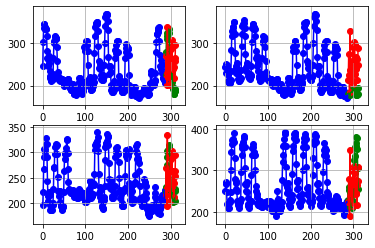

epoch = 0000, grad_step = 000068, tr_loss (epoch) = 194.336, te_loss (epoch) = 20.844
epoch = 0001, grad_step = 000136, tr_loss (epoch) = 23.171, te_loss (epoch) = 18.826
epoch = 0002, grad_step = 000204, tr_loss (epoch) = 20.758, te_loss (epoch) = 18.381
epoch = 0003, grad_step = 000272, tr_loss (epoch) = 18.847, te_loss (epoch) = 17.745
epoch = 0004, grad_step = 000340, tr_loss (epoch) = 16.317, te_loss (epoch) = 16.513
epoch = 0005, grad_step = 000408, tr_loss (epoch) = 15.420, te_loss (epoch) = 17.653
epoch = 0006, grad_step = 000476, tr_loss (epoch) = 13.939, te_loss (epoch) = 19.328
epoch = 0007, grad_step = 000544, tr_loss (epoch) = 13.939, te_loss (epoch) = 14.160
epoch = 0008, grad_step = 000612, tr_loss (epoch) = 11.011, te_loss (epoch) = 14.566
epoch = 0009, grad_step = 000680, tr_loss (epoch) = 9.871, te_loss (epoch) = 13.173


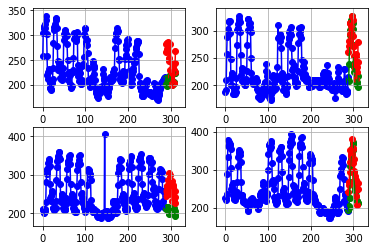

epoch = 0010, grad_step = 000748, tr_loss (epoch) = 9.447, te_loss (epoch) = 14.821
epoch = 0011, grad_step = 000816, tr_loss (epoch) = 9.088, te_loss (epoch) = 15.180
epoch = 0012, grad_step = 000884, tr_loss (epoch) = 8.178, te_loss (epoch) = 15.833
epoch = 0013, grad_step = 000952, tr_loss (epoch) = 9.435, te_loss (epoch) = 13.919
epoch = 0014, grad_step = 001020, tr_loss (epoch) = 8.078, te_loss (epoch) = 17.635
epoch = 0015, grad_step = 001088, tr_loss (epoch) = 7.260, te_loss (epoch) = 13.252
epoch = 0016, grad_step = 001156, tr_loss (epoch) = 6.464, te_loss (epoch) = 17.145
epoch = 0017, grad_step = 001224, tr_loss (epoch) = 7.027, te_loss (epoch) = 14.050
epoch = 0018, grad_step = 001292, tr_loss (epoch) = 6.352, te_loss (epoch) = 16.791
epoch = 0019, grad_step = 001360, tr_loss (epoch) = 7.512, te_loss (epoch) = 15.586


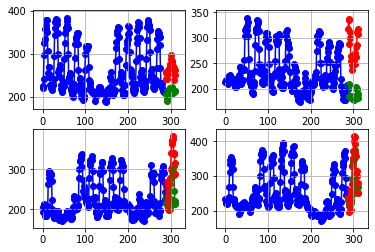

epoch = 0020, grad_step = 001428, tr_loss (epoch) = 6.285, te_loss (epoch) = 16.418
epoch = 0021, grad_step = 001496, tr_loss (epoch) = 6.689, te_loss (epoch) = 16.471
epoch = 0022, grad_step = 001564, tr_loss (epoch) = 6.304, te_loss (epoch) = 15.631
epoch = 0023, grad_step = 001632, tr_loss (epoch) = 6.458, te_loss (epoch) = 17.484
epoch = 0024, grad_step = 001700, tr_loss (epoch) = 6.370, te_loss (epoch) = 15.825
epoch = 0025, grad_step = 001768, tr_loss (epoch) = 6.303, te_loss (epoch) = 17.286
epoch = 0026, grad_step = 001836, tr_loss (epoch) = 6.422, te_loss (epoch) = 16.079
epoch = 0027, grad_step = 001904, tr_loss (epoch) = 6.135, te_loss (epoch) = 16.645
epoch = 0028, grad_step = 001972, tr_loss (epoch) = 6.445, te_loss (epoch) = 15.455
epoch = 0029, grad_step = 002040, tr_loss (epoch) = 6.002, te_loss (epoch) = 17.368


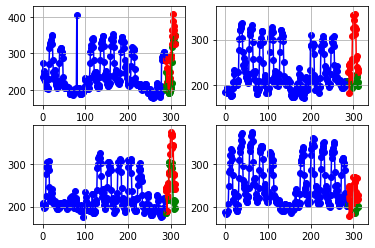

epoch = 0030, grad_step = 002108, tr_loss (epoch) = 6.921, te_loss (epoch) = 14.494
epoch = 0031, grad_step = 002176, tr_loss (epoch) = 6.015, te_loss (epoch) = 17.822
epoch = 0032, grad_step = 002244, tr_loss (epoch) = 8.009, te_loss (epoch) = 13.923
epoch = 0033, grad_step = 002312, tr_loss (epoch) = 6.280, te_loss (epoch) = 17.868
epoch = 0034, grad_step = 002380, tr_loss (epoch) = 7.238, te_loss (epoch) = 15.285
epoch = 0035, grad_step = 002448, tr_loss (epoch) = 6.389, te_loss (epoch) = 18.127
epoch = 0036, grad_step = 002516, tr_loss (epoch) = 7.151, te_loss (epoch) = 16.087
epoch = 0037, grad_step = 002584, tr_loss (epoch) = 6.313, te_loss (epoch) = 18.599
epoch = 0038, grad_step = 002652, tr_loss (epoch) = 7.289, te_loss (epoch) = 15.600
epoch = 0039, grad_step = 002720, tr_loss (epoch) = 6.326, te_loss (epoch) = 20.224


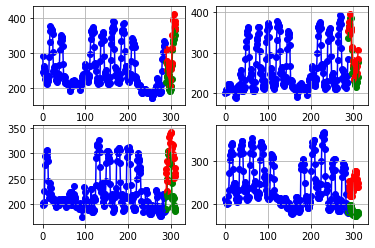

epoch = 0040, grad_step = 002788, tr_loss (epoch) = 7.972, te_loss (epoch) = 16.662
epoch = 0041, grad_step = 002856, tr_loss (epoch) = 6.463, te_loss (epoch) = 20.774
epoch = 0042, grad_step = 002924, tr_loss (epoch) = 7.676, te_loss (epoch) = 19.254
epoch = 0043, grad_step = 002992, tr_loss (epoch) = 6.587, te_loss (epoch) = 21.311
epoch = 0044, grad_step = 003060, tr_loss (epoch) = 7.400, te_loss (epoch) = 19.958
epoch = 0045, grad_step = 003128, tr_loss (epoch) = 6.516, te_loss (epoch) = 21.594
epoch = 0046, grad_step = 003196, tr_loss (epoch) = 7.239, te_loss (epoch) = 22.175
epoch = 0047, grad_step = 003264, tr_loss (epoch) = 6.937, te_loss (epoch) = 21.934
epoch = 0048, grad_step = 003332, tr_loss (epoch) = 7.272, te_loss (epoch) = 22.224
epoch = 0049, grad_step = 003400, tr_loss (epoch) = 7.177, te_loss (epoch) = 21.184


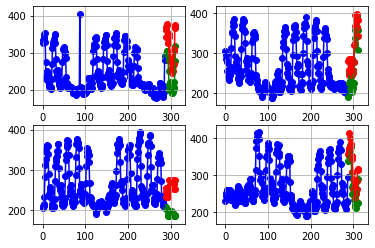

epoch = 0050, grad_step = 003468, tr_loss (epoch) = 7.064, te_loss (epoch) = 22.510
epoch = 0051, grad_step = 003536, tr_loss (epoch) = 9.597, te_loss (epoch) = 17.382
epoch = 0052, grad_step = 003604, tr_loss (epoch) = 6.354, te_loss (epoch) = 21.483
epoch = 0053, grad_step = 003672, tr_loss (epoch) = 6.684, te_loss (epoch) = 23.148
epoch = 0054, grad_step = 003740, tr_loss (epoch) = 6.615, te_loss (epoch) = 18.855
epoch = 0055, grad_step = 003808, tr_loss (epoch) = 7.348, te_loss (epoch) = 25.462
epoch = 0056, grad_step = 003876, tr_loss (epoch) = 6.708, te_loss (epoch) = 18.714
epoch = 0057, grad_step = 003944, tr_loss (epoch) = 6.895, te_loss (epoch) = 22.849
epoch = 0058, grad_step = 004012, tr_loss (epoch) = 6.491, te_loss (epoch) = 19.221
epoch = 0059, grad_step = 004080, tr_loss (epoch) = 6.406, te_loss (epoch) = 20.269


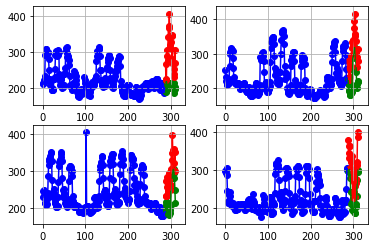

epoch = 0060, grad_step = 004148, tr_loss (epoch) = 6.146, te_loss (epoch) = 19.720
epoch = 0061, grad_step = 004216, tr_loss (epoch) = 6.166, te_loss (epoch) = 18.693
epoch = 0062, grad_step = 004284, tr_loss (epoch) = 5.820, te_loss (epoch) = 19.103
epoch = 0063, grad_step = 004352, tr_loss (epoch) = 5.877, te_loss (epoch) = 17.739
epoch = 0064, grad_step = 004420, tr_loss (epoch) = 5.562, te_loss (epoch) = 17.919
epoch = 0065, grad_step = 004488, tr_loss (epoch) = 5.676, te_loss (epoch) = 17.414
epoch = 0066, grad_step = 004556, tr_loss (epoch) = 5.501, te_loss (epoch) = 16.753
epoch = 0067, grad_step = 004624, tr_loss (epoch) = 5.970, te_loss (epoch) = 18.644
epoch = 0068, grad_step = 004692, tr_loss (epoch) = 5.698, te_loss (epoch) = 15.786
epoch = 0069, grad_step = 004760, tr_loss (epoch) = 5.978, te_loss (epoch) = 19.677


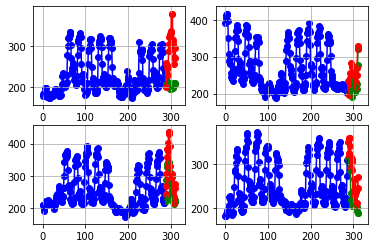

epoch = 0070, grad_step = 004828, tr_loss (epoch) = 5.627, te_loss (epoch) = 14.565
epoch = 0071, grad_step = 004896, tr_loss (epoch) = 5.384, te_loss (epoch) = 18.076
epoch = 0072, grad_step = 004964, tr_loss (epoch) = 5.301, te_loss (epoch) = 14.936
epoch = 0073, grad_step = 005032, tr_loss (epoch) = 5.164, te_loss (epoch) = 17.215
epoch = 0074, grad_step = 005100, tr_loss (epoch) = 5.134, te_loss (epoch) = 15.402
epoch = 0075, grad_step = 005168, tr_loss (epoch) = 5.107, te_loss (epoch) = 16.185
epoch = 0076, grad_step = 005236, tr_loss (epoch) = 5.036, te_loss (epoch) = 14.997
epoch = 0077, grad_step = 005304, tr_loss (epoch) = 5.003, te_loss (epoch) = 15.257
epoch = 0078, grad_step = 005372, tr_loss (epoch) = 4.919, te_loss (epoch) = 14.230
epoch = 0079, grad_step = 005440, tr_loss (epoch) = 4.926, te_loss (epoch) = 15.077


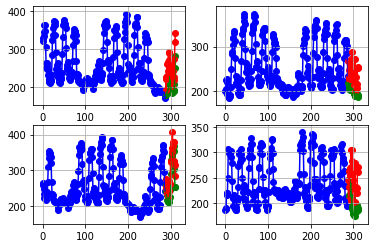

epoch = 0080, grad_step = 005508, tr_loss (epoch) = 4.818, te_loss (epoch) = 13.698
epoch = 0081, grad_step = 005576, tr_loss (epoch) = 4.997, te_loss (epoch) = 15.083
epoch = 0082, grad_step = 005644, tr_loss (epoch) = 4.842, te_loss (epoch) = 12.611
epoch = 0083, grad_step = 005712, tr_loss (epoch) = 5.055, te_loss (epoch) = 14.795
epoch = 0084, grad_step = 005780, tr_loss (epoch) = 4.815, te_loss (epoch) = 11.910
epoch = 0085, grad_step = 005848, tr_loss (epoch) = 5.040, te_loss (epoch) = 14.697
epoch = 0086, grad_step = 005916, tr_loss (epoch) = 4.830, te_loss (epoch) = 11.768
epoch = 0087, grad_step = 005984, tr_loss (epoch) = 4.863, te_loss (epoch) = 13.875
epoch = 0088, grad_step = 006052, tr_loss (epoch) = 4.685, te_loss (epoch) = 12.514
epoch = 0089, grad_step = 006120, tr_loss (epoch) = 4.745, te_loss (epoch) = 13.216


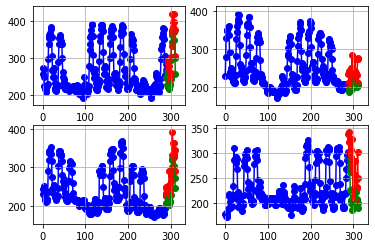

epoch = 0090, grad_step = 006188, tr_loss (epoch) = 4.658, te_loss (epoch) = 13.108
epoch = 0091, grad_step = 006256, tr_loss (epoch) = 4.939, te_loss (epoch) = 13.205
epoch = 0092, grad_step = 006324, tr_loss (epoch) = 4.685, te_loss (epoch) = 13.040
epoch = 0093, grad_step = 006392, tr_loss (epoch) = 5.129, te_loss (epoch) = 13.046
epoch = 0094, grad_step = 006460, tr_loss (epoch) = 4.778, te_loss (epoch) = 12.337
epoch = 0095, grad_step = 006528, tr_loss (epoch) = 5.010, te_loss (epoch) = 12.659
epoch = 0096, grad_step = 006596, tr_loss (epoch) = 4.632, te_loss (epoch) = 12.142
epoch = 0097, grad_step = 006664, tr_loss (epoch) = 4.654, te_loss (epoch) = 12.577
epoch = 0098, grad_step = 006732, tr_loss (epoch) = 4.556, te_loss (epoch) = 11.976
epoch = 0099, grad_step = 006800, tr_loss (epoch) = 4.599, te_loss (epoch) = 12.323


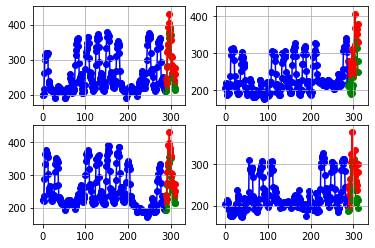

epoch = 0100, grad_step = 006868, tr_loss (epoch) = 4.529, te_loss (epoch) = 12.236
epoch = 0101, grad_step = 006936, tr_loss (epoch) = 4.679, te_loss (epoch) = 12.295
epoch = 0102, grad_step = 007004, tr_loss (epoch) = 4.471, te_loss (epoch) = 12.366
epoch = 0103, grad_step = 007072, tr_loss (epoch) = 4.736, te_loss (epoch) = 11.627
epoch = 0104, grad_step = 007140, tr_loss (epoch) = 4.425, te_loss (epoch) = 12.613
epoch = 0105, grad_step = 007208, tr_loss (epoch) = 4.692, te_loss (epoch) = 11.718
epoch = 0106, grad_step = 007276, tr_loss (epoch) = 4.390, te_loss (epoch) = 12.288
epoch = 0107, grad_step = 007344, tr_loss (epoch) = 4.521, te_loss (epoch) = 12.174
epoch = 0108, grad_step = 007412, tr_loss (epoch) = 4.302, te_loss (epoch) = 12.670
epoch = 0109, grad_step = 007480, tr_loss (epoch) = 4.687, te_loss (epoch) = 12.890


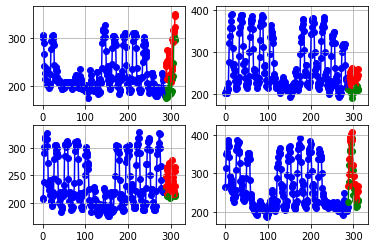

epoch = 0110, grad_step = 007548, tr_loss (epoch) = 4.424, te_loss (epoch) = 10.978
epoch = 0111, grad_step = 007616, tr_loss (epoch) = 4.744, te_loss (epoch) = 11.690
epoch = 0112, grad_step = 007684, tr_loss (epoch) = 4.548, te_loss (epoch) = 11.305
epoch = 0113, grad_step = 007752, tr_loss (epoch) = 4.989, te_loss (epoch) = 13.851
epoch = 0114, grad_step = 007820, tr_loss (epoch) = 4.823, te_loss (epoch) = 11.624
epoch = 0115, grad_step = 007888, tr_loss (epoch) = 5.651, te_loss (epoch) = 11.763
epoch = 0116, grad_step = 007956, tr_loss (epoch) = 4.473, te_loss (epoch) = 10.363
epoch = 0117, grad_step = 008024, tr_loss (epoch) = 4.282, te_loss (epoch) = 10.542
epoch = 0118, grad_step = 008092, tr_loss (epoch) = 4.297, te_loss (epoch) = 10.376
epoch = 0119, grad_step = 008160, tr_loss (epoch) = 4.322, te_loss (epoch) = 10.194


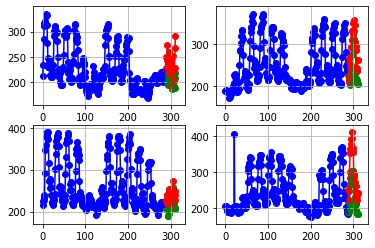

epoch = 0120, grad_step = 008228, tr_loss (epoch) = 4.239, te_loss (epoch) = 9.795
epoch = 0121, grad_step = 008296, tr_loss (epoch) = 4.158, te_loss (epoch) = 9.684
epoch = 0122, grad_step = 008364, tr_loss (epoch) = 4.101, te_loss (epoch) = 9.584
epoch = 0123, grad_step = 008432, tr_loss (epoch) = 4.058, te_loss (epoch) = 9.702
epoch = 0124, grad_step = 008500, tr_loss (epoch) = 4.092, te_loss (epoch) = 9.943
epoch = 0125, grad_step = 008568, tr_loss (epoch) = 4.123, te_loss (epoch) = 10.163
epoch = 0126, grad_step = 008636, tr_loss (epoch) = 4.166, te_loss (epoch) = 10.148
epoch = 0127, grad_step = 008704, tr_loss (epoch) = 4.174, te_loss (epoch) = 9.915
epoch = 0128, grad_step = 008772, tr_loss (epoch) = 4.139, te_loss (epoch) = 9.777
epoch = 0129, grad_step = 008840, tr_loss (epoch) = 4.137, te_loss (epoch) = 9.436


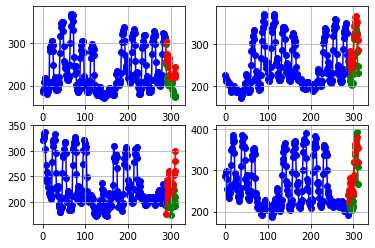

epoch = 0130, grad_step = 008908, tr_loss (epoch) = 4.007, te_loss (epoch) = 9.647
epoch = 0131, grad_step = 008976, tr_loss (epoch) = 4.004, te_loss (epoch) = 9.311
epoch = 0132, grad_step = 009044, tr_loss (epoch) = 3.925, te_loss (epoch) = 9.024
epoch = 0133, grad_step = 009112, tr_loss (epoch) = 3.884, te_loss (epoch) = 9.200
epoch = 0134, grad_step = 009180, tr_loss (epoch) = 3.901, te_loss (epoch) = 9.253
epoch = 0135, grad_step = 009248, tr_loss (epoch) = 3.841, te_loss (epoch) = 9.113
epoch = 0136, grad_step = 009316, tr_loss (epoch) = 3.823, te_loss (epoch) = 8.550
epoch = 0137, grad_step = 009384, tr_loss (epoch) = 3.822, te_loss (epoch) = 8.317
epoch = 0138, grad_step = 009452, tr_loss (epoch) = 3.861, te_loss (epoch) = 8.033
epoch = 0139, grad_step = 009520, tr_loss (epoch) = 4.040, te_loss (epoch) = 8.187


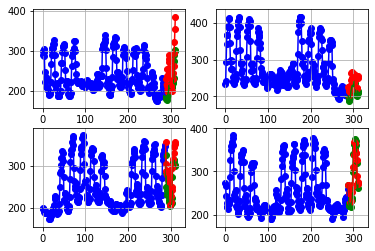

epoch = 0140, grad_step = 009588, tr_loss (epoch) = 3.845, te_loss (epoch) = 8.615
epoch = 0141, grad_step = 009656, tr_loss (epoch) = 4.077, te_loss (epoch) = 8.232
epoch = 0142, grad_step = 009724, tr_loss (epoch) = 3.697, te_loss (epoch) = 8.366
epoch = 0143, grad_step = 009792, tr_loss (epoch) = 3.742, te_loss (epoch) = 8.337
epoch = 0144, grad_step = 009860, tr_loss (epoch) = 3.639, te_loss (epoch) = 8.113
epoch = 0145, grad_step = 009928, tr_loss (epoch) = 3.672, te_loss (epoch) = 7.843
epoch = 0146, grad_step = 009996, tr_loss (epoch) = 3.557, te_loss (epoch) = 7.910
epoch = 0147, grad_step = 010064, tr_loss (epoch) = 3.575, te_loss (epoch) = 8.123
epoch = 0148, grad_step = 010132, tr_loss (epoch) = 3.632, te_loss (epoch) = 7.990
epoch = 0149, grad_step = 010200, tr_loss (epoch) = 3.679, te_loss (epoch) = 7.569


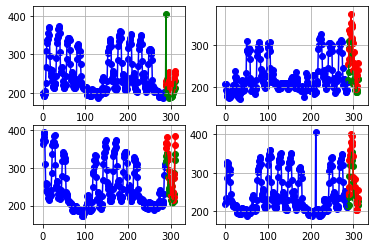

epoch = 0150, grad_step = 010268, tr_loss (epoch) = 3.561, te_loss (epoch) = 7.074
epoch = 0151, grad_step = 010336, tr_loss (epoch) = 3.624, te_loss (epoch) = 6.519
epoch = 0152, grad_step = 010404, tr_loss (epoch) = 3.647, te_loss (epoch) = 6.700
epoch = 0153, grad_step = 010472, tr_loss (epoch) = 3.515, te_loss (epoch) = 6.163
epoch = 0154, grad_step = 010540, tr_loss (epoch) = 3.387, te_loss (epoch) = 6.888
epoch = 0155, grad_step = 010608, tr_loss (epoch) = 3.452, te_loss (epoch) = 6.517
epoch = 0156, grad_step = 010676, tr_loss (epoch) = 3.330, te_loss (epoch) = 7.127
epoch = 0157, grad_step = 010744, tr_loss (epoch) = 3.446, te_loss (epoch) = 6.777
epoch = 0158, grad_step = 010812, tr_loss (epoch) = 3.324, te_loss (epoch) = 6.608
epoch = 0159, grad_step = 010880, tr_loss (epoch) = 3.373, te_loss (epoch) = 6.775


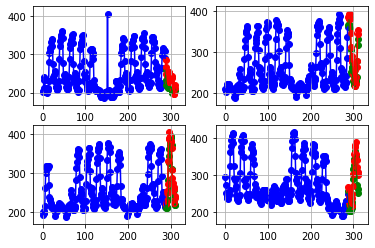

epoch = 0160, grad_step = 010948, tr_loss (epoch) = 3.242, te_loss (epoch) = 7.017
epoch = 0161, grad_step = 011016, tr_loss (epoch) = 3.391, te_loss (epoch) = 7.268
epoch = 0162, grad_step = 011084, tr_loss (epoch) = 3.301, te_loss (epoch) = 7.145
epoch = 0163, grad_step = 011152, tr_loss (epoch) = 3.543, te_loss (epoch) = 7.145
epoch = 0164, grad_step = 011220, tr_loss (epoch) = 3.379, te_loss (epoch) = 6.742
epoch = 0165, grad_step = 011288, tr_loss (epoch) = 3.643, te_loss (epoch) = 6.841
epoch = 0166, grad_step = 011356, tr_loss (epoch) = 3.246, te_loss (epoch) = 7.019
epoch = 0167, grad_step = 011424, tr_loss (epoch) = 3.736, te_loss (epoch) = 7.978
epoch = 0168, grad_step = 011492, tr_loss (epoch) = 3.461, te_loss (epoch) = 6.907
epoch = 0169, grad_step = 011560, tr_loss (epoch) = 3.762, te_loss (epoch) = 7.483


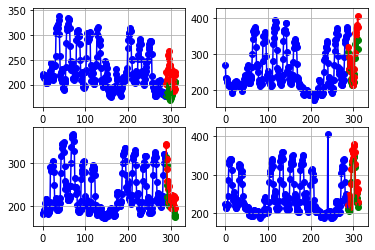

epoch = 0170, grad_step = 011628, tr_loss (epoch) = 3.247, te_loss (epoch) = 6.287
epoch = 0171, grad_step = 011696, tr_loss (epoch) = 3.170, te_loss (epoch) = 6.890
epoch = 0172, grad_step = 011764, tr_loss (epoch) = 3.141, te_loss (epoch) = 6.566
epoch = 0173, grad_step = 011832, tr_loss (epoch) = 3.160, te_loss (epoch) = 6.558
epoch = 0174, grad_step = 011900, tr_loss (epoch) = 3.010, te_loss (epoch) = 6.327
epoch = 0175, grad_step = 011968, tr_loss (epoch) = 3.082, te_loss (epoch) = 6.803
epoch = 0176, grad_step = 012036, tr_loss (epoch) = 2.975, te_loss (epoch) = 6.545
epoch = 0177, grad_step = 012104, tr_loss (epoch) = 3.087, te_loss (epoch) = 6.407
epoch = 0178, grad_step = 012172, tr_loss (epoch) = 3.102, te_loss (epoch) = 6.524
epoch = 0179, grad_step = 012240, tr_loss (epoch) = 3.217, te_loss (epoch) = 6.634


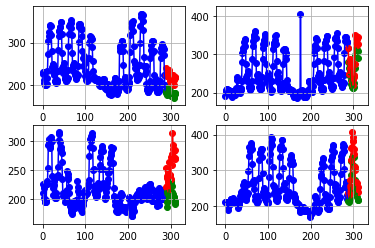

epoch = 0180, grad_step = 012308, tr_loss (epoch) = 3.173, te_loss (epoch) = 7.926
epoch = 0181, grad_step = 012376, tr_loss (epoch) = 3.154, te_loss (epoch) = 6.470
epoch = 0182, grad_step = 012444, tr_loss (epoch) = 2.999, te_loss (epoch) = 5.624
epoch = 0183, grad_step = 012512, tr_loss (epoch) = 2.932, te_loss (epoch) = 6.021
epoch = 0184, grad_step = 012580, tr_loss (epoch) = 2.887, te_loss (epoch) = 6.139
epoch = 0185, grad_step = 012648, tr_loss (epoch) = 2.901, te_loss (epoch) = 5.733
epoch = 0186, grad_step = 012716, tr_loss (epoch) = 2.844, te_loss (epoch) = 5.269
epoch = 0187, grad_step = 012784, tr_loss (epoch) = 2.742, te_loss (epoch) = 5.995
epoch = 0188, grad_step = 012852, tr_loss (epoch) = 2.717, te_loss (epoch) = 6.004
epoch = 0189, grad_step = 012920, tr_loss (epoch) = 2.863, te_loss (epoch) = 6.391


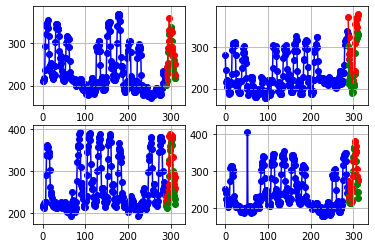

epoch = 0190, grad_step = 012988, tr_loss (epoch) = 2.951, te_loss (epoch) = 7.679
epoch = 0191, grad_step = 013056, tr_loss (epoch) = 3.131, te_loss (epoch) = 7.077
epoch = 0192, grad_step = 013124, tr_loss (epoch) = 2.995, te_loss (epoch) = 7.215
epoch = 0193, grad_step = 013192, tr_loss (epoch) = 3.055, te_loss (epoch) = 6.000
epoch = 0194, grad_step = 013260, tr_loss (epoch) = 2.851, te_loss (epoch) = 6.615
epoch = 0195, grad_step = 013328, tr_loss (epoch) = 4.020, te_loss (epoch) = 8.091
epoch = 0196, grad_step = 013396, tr_loss (epoch) = 3.513, te_loss (epoch) = 6.989
epoch = 0197, grad_step = 013464, tr_loss (epoch) = 5.085, te_loss (epoch) = 8.027
epoch = 0198, grad_step = 013532, tr_loss (epoch) = 4.417, te_loss (epoch) = 6.712
epoch = 0199, grad_step = 013600, tr_loss (epoch) = 5.995, te_loss (epoch) = 11.353


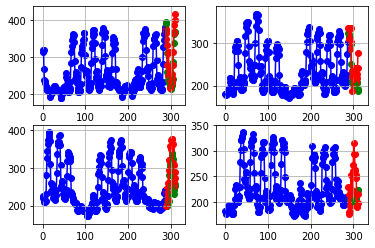

epoch = 0200, grad_step = 013668, tr_loss (epoch) = 6.035, te_loss (epoch) = 7.152
epoch = 0201, grad_step = 013736, tr_loss (epoch) = 3.940, te_loss (epoch) = 5.598
epoch = 0202, grad_step = 013804, tr_loss (epoch) = 3.272, te_loss (epoch) = 5.370
epoch = 0203, grad_step = 013872, tr_loss (epoch) = 3.102, te_loss (epoch) = 5.684
epoch = 0204, grad_step = 013940, tr_loss (epoch) = 3.250, te_loss (epoch) = 4.753
epoch = 0205, grad_step = 014008, tr_loss (epoch) = 2.852, te_loss (epoch) = 4.733
epoch = 0206, grad_step = 014076, tr_loss (epoch) = 2.772, te_loss (epoch) = 4.421
epoch = 0207, grad_step = 014144, tr_loss (epoch) = 2.655, te_loss (epoch) = 4.408
epoch = 0208, grad_step = 014212, tr_loss (epoch) = 2.576, te_loss (epoch) = 3.955
epoch = 0209, grad_step = 014280, tr_loss (epoch) = 2.497, te_loss (epoch) = 3.939


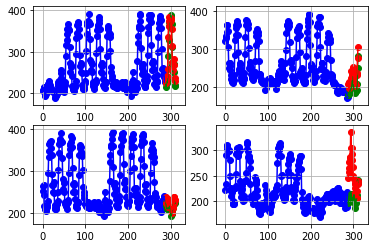

epoch = 0210, grad_step = 014348, tr_loss (epoch) = 2.451, te_loss (epoch) = 3.616
epoch = 0211, grad_step = 014416, tr_loss (epoch) = 2.434, te_loss (epoch) = 3.763
epoch = 0212, grad_step = 014484, tr_loss (epoch) = 2.412, te_loss (epoch) = 3.611
epoch = 0213, grad_step = 014552, tr_loss (epoch) = 2.373, te_loss (epoch) = 3.757
epoch = 0214, grad_step = 014620, tr_loss (epoch) = 2.401, te_loss (epoch) = 3.878
epoch = 0215, grad_step = 014688, tr_loss (epoch) = 2.326, te_loss (epoch) = 3.910
epoch = 0216, grad_step = 014756, tr_loss (epoch) = 2.351, te_loss (epoch) = 3.823
epoch = 0217, grad_step = 014824, tr_loss (epoch) = 2.292, te_loss (epoch) = 3.811
epoch = 0218, grad_step = 014892, tr_loss (epoch) = 2.321, te_loss (epoch) = 4.024
epoch = 0219, grad_step = 014960, tr_loss (epoch) = 2.365, te_loss (epoch) = 4.048


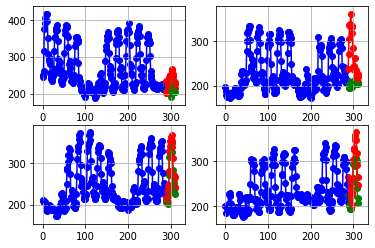

epoch = 0220, grad_step = 015028, tr_loss (epoch) = 2.402, te_loss (epoch) = 5.111
epoch = 0221, grad_step = 015096, tr_loss (epoch) = 2.361, te_loss (epoch) = 4.122
epoch = 0222, grad_step = 015164, tr_loss (epoch) = 2.305, te_loss (epoch) = 4.351
epoch = 0223, grad_step = 015232, tr_loss (epoch) = 2.302, te_loss (epoch) = 4.615
epoch = 0224, grad_step = 015300, tr_loss (epoch) = 2.358, te_loss (epoch) = 3.967
epoch = 0225, grad_step = 015368, tr_loss (epoch) = 2.296, te_loss (epoch) = 4.840
epoch = 0226, grad_step = 015436, tr_loss (epoch) = 2.374, te_loss (epoch) = 4.534
epoch = 0227, grad_step = 015504, tr_loss (epoch) = 2.285, te_loss (epoch) = 4.250
epoch = 0228, grad_step = 015572, tr_loss (epoch) = 2.316, te_loss (epoch) = 3.953
epoch = 0229, grad_step = 015640, tr_loss (epoch) = 2.198, te_loss (epoch) = 4.429


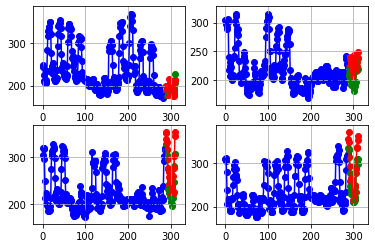

epoch = 0230, grad_step = 015708, tr_loss (epoch) = 2.170, te_loss (epoch) = 4.716
epoch = 0231, grad_step = 015776, tr_loss (epoch) = 2.183, te_loss (epoch) = 4.462
epoch = 0232, grad_step = 015844, tr_loss (epoch) = 2.221, te_loss (epoch) = 4.641
epoch = 0233, grad_step = 015912, tr_loss (epoch) = 2.384, te_loss (epoch) = 6.049
epoch = 0234, grad_step = 015980, tr_loss (epoch) = 2.653, te_loss (epoch) = 5.060
epoch = 0235, grad_step = 016048, tr_loss (epoch) = 2.785, te_loss (epoch) = 5.310
epoch = 0236, grad_step = 016116, tr_loss (epoch) = 2.607, te_loss (epoch) = 5.376
epoch = 0237, grad_step = 016184, tr_loss (epoch) = 2.609, te_loss (epoch) = 7.380
epoch = 0238, grad_step = 016252, tr_loss (epoch) = 2.364, te_loss (epoch) = 5.918
epoch = 0239, grad_step = 016320, tr_loss (epoch) = 2.387, te_loss (epoch) = 5.647


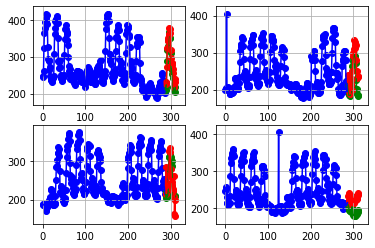

epoch = 0240, grad_step = 016388, tr_loss (epoch) = 2.273, te_loss (epoch) = 4.523
epoch = 0241, grad_step = 016456, tr_loss (epoch) = 2.292, te_loss (epoch) = 5.196
epoch = 0242, grad_step = 016524, tr_loss (epoch) = 2.307, te_loss (epoch) = 4.827
epoch = 0243, grad_step = 016592, tr_loss (epoch) = 2.253, te_loss (epoch) = 4.742
epoch = 0244, grad_step = 016660, tr_loss (epoch) = 2.171, te_loss (epoch) = 4.207
epoch = 0245, grad_step = 016728, tr_loss (epoch) = 2.111, te_loss (epoch) = 4.248
epoch = 0246, grad_step = 016796, tr_loss (epoch) = 2.068, te_loss (epoch) = 5.460
epoch = 0247, grad_step = 016864, tr_loss (epoch) = 2.141, te_loss (epoch) = 5.122
epoch = 0248, grad_step = 016932, tr_loss (epoch) = 2.249, te_loss (epoch) = 5.570
epoch = 0249, grad_step = 017000, tr_loss (epoch) = 2.242, te_loss (epoch) = 4.879


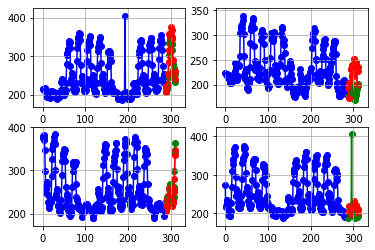

epoch = 0250, grad_step = 017068, tr_loss (epoch) = 2.135, te_loss (epoch) = 4.205
epoch = 0251, grad_step = 017136, tr_loss (epoch) = 2.167, te_loss (epoch) = 4.155
epoch = 0252, grad_step = 017204, tr_loss (epoch) = 2.098, te_loss (epoch) = 3.465
epoch = 0253, grad_step = 017272, tr_loss (epoch) = 2.171, te_loss (epoch) = 4.159
epoch = 0254, grad_step = 017340, tr_loss (epoch) = 2.169, te_loss (epoch) = 4.215
epoch = 0255, grad_step = 017408, tr_loss (epoch) = 2.419, te_loss (epoch) = 4.754
epoch = 0256, grad_step = 017476, tr_loss (epoch) = 2.190, te_loss (epoch) = 4.653
epoch = 0257, grad_step = 017544, tr_loss (epoch) = 2.445, te_loss (epoch) = 6.249
epoch = 0258, grad_step = 017612, tr_loss (epoch) = 2.194, te_loss (epoch) = 6.250
epoch = 0259, grad_step = 017680, tr_loss (epoch) = 2.363, te_loss (epoch) = 4.052


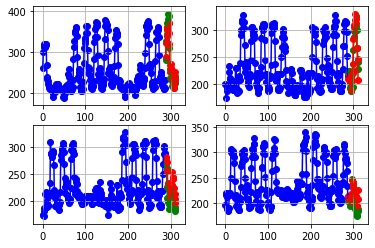

epoch = 0260, grad_step = 017748, tr_loss (epoch) = 1.983, te_loss (epoch) = 3.733
epoch = 0261, grad_step = 017816, tr_loss (epoch) = 2.134, te_loss (epoch) = 3.329
epoch = 0262, grad_step = 017884, tr_loss (epoch) = 2.017, te_loss (epoch) = 4.153
epoch = 0263, grad_step = 017952, tr_loss (epoch) = 2.055, te_loss (epoch) = 3.332
epoch = 0264, grad_step = 018020, tr_loss (epoch) = 1.802, te_loss (epoch) = 3.458
epoch = 0265, grad_step = 018088, tr_loss (epoch) = 1.791, te_loss (epoch) = 2.785
epoch = 0266, grad_step = 018156, tr_loss (epoch) = 1.805, te_loss (epoch) = 4.432
epoch = 0267, grad_step = 018224, tr_loss (epoch) = 1.877, te_loss (epoch) = 4.728
epoch = 0268, grad_step = 018292, tr_loss (epoch) = 1.924, te_loss (epoch) = 4.254
epoch = 0269, grad_step = 018360, tr_loss (epoch) = 2.182, te_loss (epoch) = 5.335


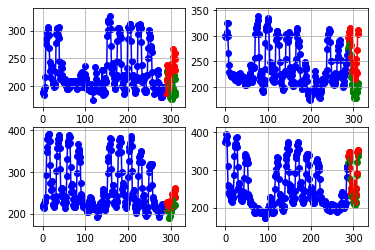

epoch = 0270, grad_step = 018428, tr_loss (epoch) = 2.312, te_loss (epoch) = 5.261
epoch = 0271, grad_step = 018496, tr_loss (epoch) = 1.970, te_loss (epoch) = 4.227
epoch = 0272, grad_step = 018564, tr_loss (epoch) = 1.786, te_loss (epoch) = 3.473
epoch = 0273, grad_step = 018632, tr_loss (epoch) = 1.800, te_loss (epoch) = 3.340
epoch = 0274, grad_step = 018700, tr_loss (epoch) = 1.875, te_loss (epoch) = 3.464
epoch = 0275, grad_step = 018768, tr_loss (epoch) = 1.829, te_loss (epoch) = 3.560
epoch = 0276, grad_step = 018836, tr_loss (epoch) = 1.913, te_loss (epoch) = 4.221
epoch = 0277, grad_step = 018904, tr_loss (epoch) = 1.915, te_loss (epoch) = 3.747
epoch = 0278, grad_step = 018972, tr_loss (epoch) = 1.905, te_loss (epoch) = 2.625
epoch = 0279, grad_step = 019040, tr_loss (epoch) = 1.882, te_loss (epoch) = 2.839


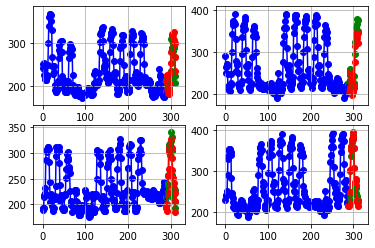

epoch = 0280, grad_step = 019108, tr_loss (epoch) = 1.856, te_loss (epoch) = 2.187
epoch = 0281, grad_step = 019176, tr_loss (epoch) = 1.827, te_loss (epoch) = 3.638
epoch = 0282, grad_step = 019244, tr_loss (epoch) = 2.166, te_loss (epoch) = 6.929
epoch = 0283, grad_step = 019312, tr_loss (epoch) = 2.860, te_loss (epoch) = 3.835
epoch = 0284, grad_step = 019380, tr_loss (epoch) = 2.713, te_loss (epoch) = 5.680
epoch = 0285, grad_step = 019448, tr_loss (epoch) = 2.370, te_loss (epoch) = 4.729
epoch = 0286, grad_step = 019516, tr_loss (epoch) = 2.188, te_loss (epoch) = 4.716
epoch = 0287, grad_step = 019584, tr_loss (epoch) = 1.891, te_loss (epoch) = 3.207
epoch = 0288, grad_step = 019652, tr_loss (epoch) = 1.823, te_loss (epoch) = 5.279
epoch = 0289, grad_step = 019720, tr_loss (epoch) = 1.886, te_loss (epoch) = 3.008


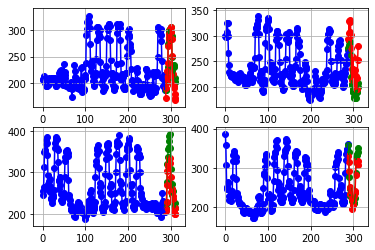

epoch = 0290, grad_step = 019788, tr_loss (epoch) = 1.731, te_loss (epoch) = 4.358
epoch = 0291, grad_step = 019856, tr_loss (epoch) = 1.772, te_loss (epoch) = 3.094
epoch = 0292, grad_step = 019924, tr_loss (epoch) = 1.616, te_loss (epoch) = 2.726
epoch = 0293, grad_step = 019992, tr_loss (epoch) = 1.562, te_loss (epoch) = 2.506
epoch = 0294, grad_step = 020060, tr_loss (epoch) = 1.481, te_loss (epoch) = 2.729
epoch = 0295, grad_step = 020128, tr_loss (epoch) = 1.470, te_loss (epoch) = 2.863
epoch = 0296, grad_step = 020196, tr_loss (epoch) = 1.451, te_loss (epoch) = 2.944
epoch = 0297, grad_step = 020264, tr_loss (epoch) = 1.469, te_loss (epoch) = 3.051
epoch = 0298, grad_step = 020332, tr_loss (epoch) = 1.431, te_loss (epoch) = 2.928
epoch = 0299, grad_step = 020400, tr_loss (epoch) = 1.407, te_loss (epoch) = 2.855


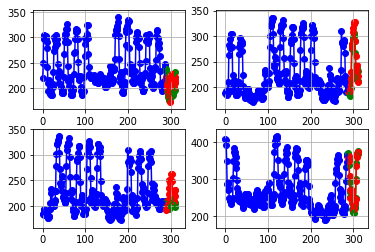

epoch = 0300, grad_step = 020468, tr_loss (epoch) = 1.417, te_loss (epoch) = 2.922
epoch = 0301, grad_step = 020536, tr_loss (epoch) = 1.404, te_loss (epoch) = 2.999
epoch = 0302, grad_step = 020604, tr_loss (epoch) = 1.398, te_loss (epoch) = 3.519
epoch = 0303, grad_step = 020672, tr_loss (epoch) = 1.468, te_loss (epoch) = 3.310
epoch = 0304, grad_step = 020740, tr_loss (epoch) = 1.451, te_loss (epoch) = 3.452
epoch = 0305, grad_step = 020808, tr_loss (epoch) = 1.542, te_loss (epoch) = 3.080
epoch = 0306, grad_step = 020876, tr_loss (epoch) = 1.662, te_loss (epoch) = 4.578
epoch = 0307, grad_step = 020944, tr_loss (epoch) = 1.589, te_loss (epoch) = 2.955
epoch = 0308, grad_step = 021012, tr_loss (epoch) = 1.565, te_loss (epoch) = 3.155
epoch = 0309, grad_step = 021080, tr_loss (epoch) = 1.684, te_loss (epoch) = 3.050


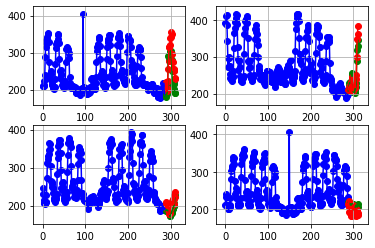

epoch = 0310, grad_step = 021148, tr_loss (epoch) = 1.494, te_loss (epoch) = 4.086
epoch = 0311, grad_step = 021216, tr_loss (epoch) = 1.493, te_loss (epoch) = 3.045
epoch = 0312, grad_step = 021284, tr_loss (epoch) = 1.403, te_loss (epoch) = 2.716
epoch = 0313, grad_step = 021352, tr_loss (epoch) = 1.415, te_loss (epoch) = 2.973
epoch = 0314, grad_step = 021420, tr_loss (epoch) = 1.415, te_loss (epoch) = 3.105
epoch = 0315, grad_step = 021488, tr_loss (epoch) = 1.444, te_loss (epoch) = 3.375
epoch = 0316, grad_step = 021556, tr_loss (epoch) = 1.397, te_loss (epoch) = 3.163
epoch = 0317, grad_step = 021624, tr_loss (epoch) = 1.415, te_loss (epoch) = 3.358
epoch = 0318, grad_step = 021692, tr_loss (epoch) = 1.354, te_loss (epoch) = 3.773
epoch = 0319, grad_step = 021760, tr_loss (epoch) = 1.359, te_loss (epoch) = 4.082


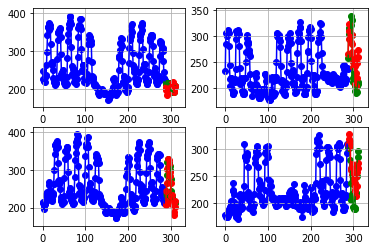

epoch = 0320, grad_step = 021828, tr_loss (epoch) = 1.304, te_loss (epoch) = 4.916
epoch = 0321, grad_step = 021896, tr_loss (epoch) = 1.373, te_loss (epoch) = 4.539
epoch = 0322, grad_step = 021964, tr_loss (epoch) = 1.311, te_loss (epoch) = 5.088
epoch = 0323, grad_step = 022032, tr_loss (epoch) = 1.378, te_loss (epoch) = 5.394
epoch = 0324, grad_step = 022100, tr_loss (epoch) = 1.337, te_loss (epoch) = 6.668
epoch = 0325, grad_step = 022168, tr_loss (epoch) = 1.416, te_loss (epoch) = 6.872
epoch = 0326, grad_step = 022236, tr_loss (epoch) = 1.562, te_loss (epoch) = 5.849
epoch = 0327, grad_step = 022304, tr_loss (epoch) = 2.357, te_loss (epoch) = 10.388
epoch = 0328, grad_step = 022372, tr_loss (epoch) = 2.662, te_loss (epoch) = 11.827
epoch = 0329, grad_step = 022440, tr_loss (epoch) = 2.442, te_loss (epoch) = 9.359


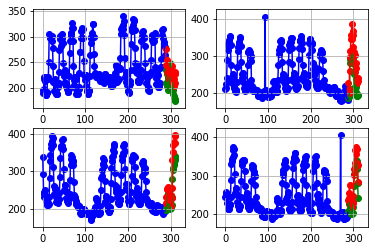

epoch = 0330, grad_step = 022508, tr_loss (epoch) = 2.019, te_loss (epoch) = 7.942
epoch = 0331, grad_step = 022576, tr_loss (epoch) = 1.807, te_loss (epoch) = 8.869
epoch = 0332, grad_step = 022644, tr_loss (epoch) = 2.059, te_loss (epoch) = 8.167
epoch = 0333, grad_step = 022712, tr_loss (epoch) = 1.985, te_loss (epoch) = 11.388
epoch = 0334, grad_step = 022780, tr_loss (epoch) = 2.332, te_loss (epoch) = 7.300
epoch = 0335, grad_step = 022848, tr_loss (epoch) = 1.889, te_loss (epoch) = 7.328
epoch = 0336, grad_step = 022916, tr_loss (epoch) = 1.717, te_loss (epoch) = 6.627
epoch = 0337, grad_step = 022984, tr_loss (epoch) = 1.619, te_loss (epoch) = 5.613
epoch = 0338, grad_step = 023052, tr_loss (epoch) = 1.465, te_loss (epoch) = 4.830
epoch = 0339, grad_step = 023120, tr_loss (epoch) = 1.518, te_loss (epoch) = 5.560


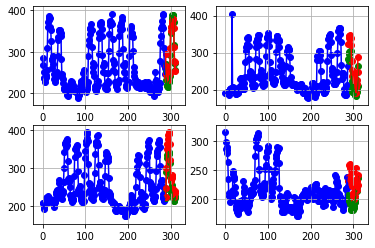

epoch = 0340, grad_step = 023188, tr_loss (epoch) = 1.664, te_loss (epoch) = 6.025
epoch = 0341, grad_step = 023256, tr_loss (epoch) = 1.895, te_loss (epoch) = 6.945
epoch = 0342, grad_step = 023324, tr_loss (epoch) = 2.069, te_loss (epoch) = 6.225
epoch = 0343, grad_step = 023392, tr_loss (epoch) = 1.874, te_loss (epoch) = 6.927
epoch = 0344, grad_step = 023460, tr_loss (epoch) = 1.773, te_loss (epoch) = 7.764
epoch = 0345, grad_step = 023528, tr_loss (epoch) = 1.793, te_loss (epoch) = 4.475
epoch = 0346, grad_step = 023596, tr_loss (epoch) = 1.586, te_loss (epoch) = 4.576
epoch = 0347, grad_step = 023664, tr_loss (epoch) = 1.523, te_loss (epoch) = 4.210
epoch = 0348, grad_step = 023732, tr_loss (epoch) = 1.413, te_loss (epoch) = 4.210
epoch = 0349, grad_step = 023800, tr_loss (epoch) = 1.360, te_loss (epoch) = 3.422


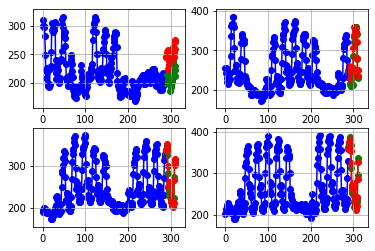

epoch = 0350, grad_step = 023868, tr_loss (epoch) = 1.273, te_loss (epoch) = 3.300
epoch = 0351, grad_step = 023936, tr_loss (epoch) = 1.240, te_loss (epoch) = 2.691
epoch = 0352, grad_step = 024004, tr_loss (epoch) = 1.190, te_loss (epoch) = 2.635
epoch = 0353, grad_step = 024072, tr_loss (epoch) = 1.175, te_loss (epoch) = 2.284
epoch = 0354, grad_step = 024140, tr_loss (epoch) = 1.160, te_loss (epoch) = 2.416
epoch = 0355, grad_step = 024208, tr_loss (epoch) = 1.144, te_loss (epoch) = 2.432
epoch = 0356, grad_step = 024276, tr_loss (epoch) = 1.135, te_loss (epoch) = 2.516
epoch = 0357, grad_step = 024344, tr_loss (epoch) = 1.121, te_loss (epoch) = 2.692
epoch = 0358, grad_step = 024412, tr_loss (epoch) = 1.130, te_loss (epoch) = 2.754
epoch = 0359, grad_step = 024480, tr_loss (epoch) = 1.136, te_loss (epoch) = 3.058


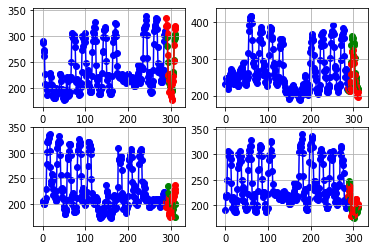

epoch = 0360, grad_step = 024548, tr_loss (epoch) = 1.141, te_loss (epoch) = 2.907
epoch = 0361, grad_step = 024616, tr_loss (epoch) = 1.155, te_loss (epoch) = 2.922
epoch = 0362, grad_step = 024684, tr_loss (epoch) = 1.118, te_loss (epoch) = 3.678
epoch = 0363, grad_step = 024752, tr_loss (epoch) = 1.207, te_loss (epoch) = 5.003
epoch = 0364, grad_step = 024820, tr_loss (epoch) = 1.339, te_loss (epoch) = 9.229
epoch = 0365, grad_step = 024888, tr_loss (epoch) = 1.632, te_loss (epoch) = 9.050
epoch = 0366, grad_step = 024956, tr_loss (epoch) = 1.655, te_loss (epoch) = 7.521
epoch = 0367, grad_step = 025024, tr_loss (epoch) = 1.549, te_loss (epoch) = 5.639
epoch = 0368, grad_step = 025092, tr_loss (epoch) = 1.338, te_loss (epoch) = 5.363
epoch = 0369, grad_step = 025160, tr_loss (epoch) = 1.210, te_loss (epoch) = 4.924


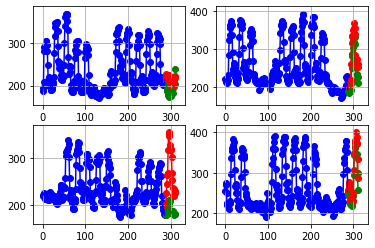

epoch = 0370, grad_step = 025228, tr_loss (epoch) = 1.166, te_loss (epoch) = 5.498
epoch = 0371, grad_step = 025296, tr_loss (epoch) = 1.198, te_loss (epoch) = 5.549
epoch = 0372, grad_step = 025364, tr_loss (epoch) = 1.156, te_loss (epoch) = 6.061
epoch = 0373, grad_step = 025432, tr_loss (epoch) = 1.192, te_loss (epoch) = 4.984
epoch = 0374, grad_step = 025500, tr_loss (epoch) = 1.170, te_loss (epoch) = 6.269
epoch = 0375, grad_step = 025568, tr_loss (epoch) = 1.261, te_loss (epoch) = 4.841
epoch = 0376, grad_step = 025636, tr_loss (epoch) = 1.174, te_loss (epoch) = 6.230
epoch = 0377, grad_step = 025704, tr_loss (epoch) = 1.227, te_loss (epoch) = 5.493
epoch = 0378, grad_step = 025772, tr_loss (epoch) = 1.157, te_loss (epoch) = 6.802
epoch = 0379, grad_step = 025840, tr_loss (epoch) = 1.236, te_loss (epoch) = 6.511


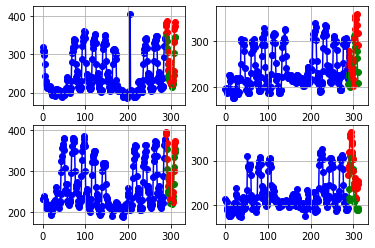

epoch = 0380, grad_step = 025908, tr_loss (epoch) = 1.250, te_loss (epoch) = 6.951
epoch = 0381, grad_step = 025976, tr_loss (epoch) = 1.217, te_loss (epoch) = 6.994
epoch = 0382, grad_step = 026044, tr_loss (epoch) = 1.214, te_loss (epoch) = 7.159
epoch = 0383, grad_step = 026112, tr_loss (epoch) = 1.237, te_loss (epoch) = 7.556
epoch = 0384, grad_step = 026180, tr_loss (epoch) = 1.284, te_loss (epoch) = 10.157
epoch = 0385, grad_step = 026248, tr_loss (epoch) = 1.545, te_loss (epoch) = 9.155
epoch = 0386, grad_step = 026316, tr_loss (epoch) = 1.899, te_loss (epoch) = 10.421
epoch = 0387, grad_step = 026384, tr_loss (epoch) = 1.995, te_loss (epoch) = 7.628
epoch = 0388, grad_step = 026452, tr_loss (epoch) = 1.935, te_loss (epoch) = 8.490
epoch = 0389, grad_step = 026520, tr_loss (epoch) = 2.237, te_loss (epoch) = 11.823


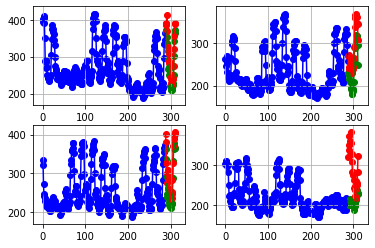

epoch = 0390, grad_step = 026588, tr_loss (epoch) = 2.049, te_loss (epoch) = 10.067
epoch = 0391, grad_step = 026656, tr_loss (epoch) = 1.829, te_loss (epoch) = 6.025
epoch = 0392, grad_step = 026724, tr_loss (epoch) = 1.438, te_loss (epoch) = 4.605
epoch = 0393, grad_step = 026792, tr_loss (epoch) = 1.318, te_loss (epoch) = 3.576
epoch = 0394, grad_step = 026860, tr_loss (epoch) = 1.363, te_loss (epoch) = 3.188
epoch = 0395, grad_step = 026928, tr_loss (epoch) = 1.254, te_loss (epoch) = 2.999
epoch = 0396, grad_step = 026996, tr_loss (epoch) = 1.267, te_loss (epoch) = 2.490
epoch = 0397, grad_step = 027064, tr_loss (epoch) = 1.302, te_loss (epoch) = 2.383
epoch = 0398, grad_step = 027132, tr_loss (epoch) = 1.256, te_loss (epoch) = 2.446
epoch = 0399, grad_step = 027200, tr_loss (epoch) = 1.236, te_loss (epoch) = 2.575


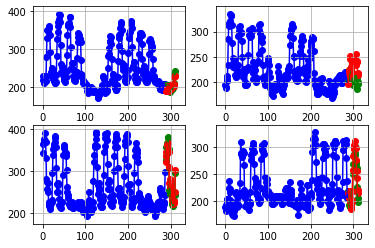

epoch = 0400, grad_step = 027268, tr_loss (epoch) = 1.094, te_loss (epoch) = 2.991
epoch = 0401, grad_step = 027336, tr_loss (epoch) = 1.093, te_loss (epoch) = 3.359
epoch = 0402, grad_step = 027404, tr_loss (epoch) = 1.070, te_loss (epoch) = 3.629
epoch = 0403, grad_step = 027472, tr_loss (epoch) = 1.106, te_loss (epoch) = 3.965
epoch = 0404, grad_step = 027540, tr_loss (epoch) = 1.098, te_loss (epoch) = 4.830
epoch = 0405, grad_step = 027608, tr_loss (epoch) = 1.156, te_loss (epoch) = 4.727
epoch = 0406, grad_step = 027676, tr_loss (epoch) = 1.065, te_loss (epoch) = 6.519
epoch = 0407, grad_step = 027744, tr_loss (epoch) = 1.132, te_loss (epoch) = 6.248
epoch = 0408, grad_step = 027812, tr_loss (epoch) = 1.029, te_loss (epoch) = 6.798
epoch = 0409, grad_step = 027880, tr_loss (epoch) = 1.049, te_loss (epoch) = 5.623


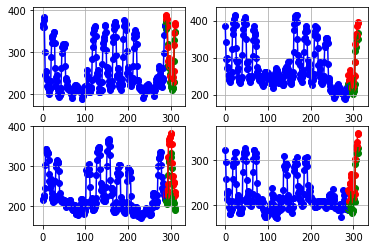

epoch = 0410, grad_step = 027948, tr_loss (epoch) = 0.975, te_loss (epoch) = 4.872
epoch = 0411, grad_step = 028016, tr_loss (epoch) = 1.002, te_loss (epoch) = 4.001
epoch = 0412, grad_step = 028084, tr_loss (epoch) = 1.005, te_loss (epoch) = 3.461
epoch = 0413, grad_step = 028152, tr_loss (epoch) = 1.037, te_loss (epoch) = 3.061
epoch = 0414, grad_step = 028220, tr_loss (epoch) = 1.044, te_loss (epoch) = 2.582
epoch = 0415, grad_step = 028288, tr_loss (epoch) = 1.077, te_loss (epoch) = 2.799
epoch = 0416, grad_step = 028356, tr_loss (epoch) = 1.085, te_loss (epoch) = 2.584
epoch = 0417, grad_step = 028424, tr_loss (epoch) = 1.110, te_loss (epoch) = 2.802
epoch = 0418, grad_step = 028492, tr_loss (epoch) = 1.121, te_loss (epoch) = 3.001
epoch = 0419, grad_step = 028560, tr_loss (epoch) = 1.202, te_loss (epoch) = 3.017


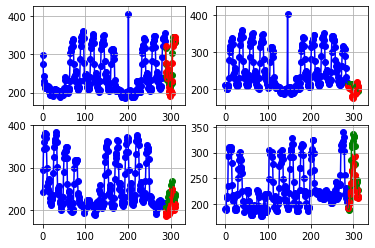

epoch = 0420, grad_step = 028628, tr_loss (epoch) = 1.216, te_loss (epoch) = 3.412
epoch = 0421, grad_step = 028696, tr_loss (epoch) = 1.453, te_loss (epoch) = 6.264
epoch = 0422, grad_step = 028764, tr_loss (epoch) = 1.373, te_loss (epoch) = 3.522
epoch = 0423, grad_step = 028832, tr_loss (epoch) = 1.248, te_loss (epoch) = 3.066
epoch = 0424, grad_step = 028900, tr_loss (epoch) = 1.194, te_loss (epoch) = 4.193
epoch = 0425, grad_step = 028968, tr_loss (epoch) = 1.222, te_loss (epoch) = 5.011
epoch = 0426, grad_step = 029036, tr_loss (epoch) = 1.291, te_loss (epoch) = 9.187
epoch = 0427, grad_step = 029104, tr_loss (epoch) = 1.530, te_loss (epoch) = 9.291
epoch = 0428, grad_step = 029172, tr_loss (epoch) = 1.504, te_loss (epoch) = 11.375
epoch = 0429, grad_step = 029240, tr_loss (epoch) = 1.704, te_loss (epoch) = 8.357


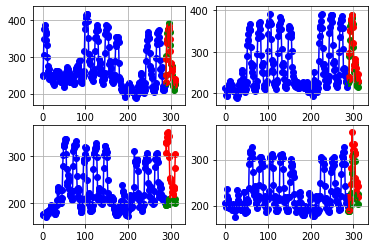

epoch = 0430, grad_step = 029308, tr_loss (epoch) = 1.501, te_loss (epoch) = 4.939
epoch = 0431, grad_step = 029376, tr_loss (epoch) = 1.374, te_loss (epoch) = 4.275
epoch = 0432, grad_step = 029444, tr_loss (epoch) = 1.127, te_loss (epoch) = 5.339
epoch = 0433, grad_step = 029512, tr_loss (epoch) = 1.082, te_loss (epoch) = 6.467
epoch = 0434, grad_step = 029580, tr_loss (epoch) = 1.104, te_loss (epoch) = 8.031
epoch = 0435, grad_step = 029648, tr_loss (epoch) = 1.065, te_loss (epoch) = 6.500
epoch = 0436, grad_step = 029716, tr_loss (epoch) = 1.016, te_loss (epoch) = 6.155
epoch = 0437, grad_step = 029784, tr_loss (epoch) = 0.988, te_loss (epoch) = 4.909
epoch = 0438, grad_step = 029852, tr_loss (epoch) = 0.993, te_loss (epoch) = 3.797
epoch = 0439, grad_step = 029920, tr_loss (epoch) = 0.994, te_loss (epoch) = 3.368


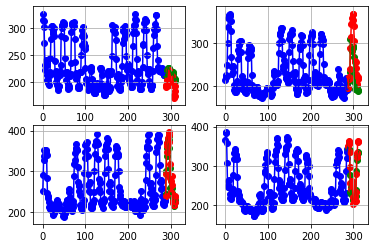

epoch = 0440, grad_step = 029988, tr_loss (epoch) = 1.041, te_loss (epoch) = 2.700
epoch = 0441, grad_step = 030056, tr_loss (epoch) = 1.028, te_loss (epoch) = 2.894
epoch = 0442, grad_step = 030124, tr_loss (epoch) = 1.059, te_loss (epoch) = 2.541
epoch = 0443, grad_step = 030192, tr_loss (epoch) = 1.032, te_loss (epoch) = 2.757
epoch = 0444, grad_step = 030260, tr_loss (epoch) = 1.077, te_loss (epoch) = 2.669
epoch = 0445, grad_step = 030328, tr_loss (epoch) = 1.090, te_loss (epoch) = 3.053
epoch = 0446, grad_step = 030396, tr_loss (epoch) = 1.047, te_loss (epoch) = 2.675
epoch = 0447, grad_step = 030464, tr_loss (epoch) = 0.987, te_loss (epoch) = 3.735
epoch = 0448, grad_step = 030532, tr_loss (epoch) = 1.066, te_loss (epoch) = 5.588
epoch = 0449, grad_step = 030600, tr_loss (epoch) = 1.174, te_loss (epoch) = 8.841


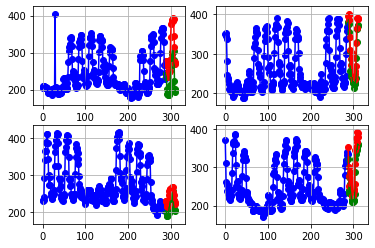

epoch = 0450, grad_step = 030668, tr_loss (epoch) = 1.481, te_loss (epoch) = 9.198
epoch = 0451, grad_step = 030736, tr_loss (epoch) = 1.299, te_loss (epoch) = 8.145
epoch = 0452, grad_step = 030804, tr_loss (epoch) = 1.214, te_loss (epoch) = 6.671
epoch = 0453, grad_step = 030872, tr_loss (epoch) = 1.105, te_loss (epoch) = 6.066
epoch = 0454, grad_step = 030940, tr_loss (epoch) = 1.032, te_loss (epoch) = 4.489
epoch = 0455, grad_step = 031008, tr_loss (epoch) = 0.969, te_loss (epoch) = 3.868
epoch = 0456, grad_step = 031076, tr_loss (epoch) = 0.971, te_loss (epoch) = 4.824
epoch = 0457, grad_step = 031144, tr_loss (epoch) = 0.945, te_loss (epoch) = 3.001
epoch = 0458, grad_step = 031212, tr_loss (epoch) = 0.925, te_loss (epoch) = 2.643
epoch = 0459, grad_step = 031280, tr_loss (epoch) = 0.954, te_loss (epoch) = 2.406


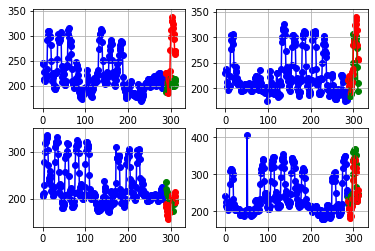

epoch = 0460, grad_step = 031348, tr_loss (epoch) = 0.991, te_loss (epoch) = 3.119
epoch = 0461, grad_step = 031416, tr_loss (epoch) = 1.023, te_loss (epoch) = 3.228
epoch = 0462, grad_step = 031484, tr_loss (epoch) = 1.050, te_loss (epoch) = 3.732
epoch = 0463, grad_step = 031552, tr_loss (epoch) = 1.053, te_loss (epoch) = 3.671
epoch = 0464, grad_step = 031620, tr_loss (epoch) = 1.043, te_loss (epoch) = 4.679
epoch = 0465, grad_step = 031688, tr_loss (epoch) = 1.082, te_loss (epoch) = 7.588
epoch = 0466, grad_step = 031756, tr_loss (epoch) = 1.300, te_loss (epoch) = 11.167
epoch = 0467, grad_step = 031824, tr_loss (epoch) = 1.439, te_loss (epoch) = 9.324
epoch = 0468, grad_step = 031892, tr_loss (epoch) = 1.305, te_loss (epoch) = 7.078
epoch = 0469, grad_step = 031960, tr_loss (epoch) = 1.133, te_loss (epoch) = 5.756


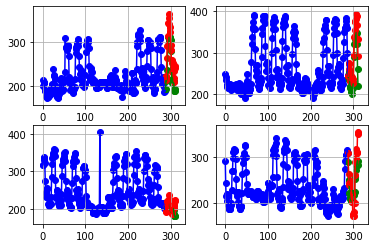

epoch = 0470, grad_step = 032028, tr_loss (epoch) = 0.999, te_loss (epoch) = 3.622
epoch = 0471, grad_step = 032096, tr_loss (epoch) = 0.905, te_loss (epoch) = 2.821
epoch = 0472, grad_step = 032164, tr_loss (epoch) = 0.865, te_loss (epoch) = 2.524
epoch = 0473, grad_step = 032232, tr_loss (epoch) = 0.923, te_loss (epoch) = 2.414
epoch = 0474, grad_step = 032300, tr_loss (epoch) = 0.939, te_loss (epoch) = 2.551
epoch = 0475, grad_step = 032368, tr_loss (epoch) = 0.969, te_loss (epoch) = 2.774
epoch = 0476, grad_step = 032436, tr_loss (epoch) = 1.012, te_loss (epoch) = 3.357
epoch = 0477, grad_step = 032504, tr_loss (epoch) = 1.001, te_loss (epoch) = 4.683
epoch = 0478, grad_step = 032572, tr_loss (epoch) = 1.145, te_loss (epoch) = 8.352
epoch = 0479, grad_step = 032640, tr_loss (epoch) = 1.167, te_loss (epoch) = 7.448


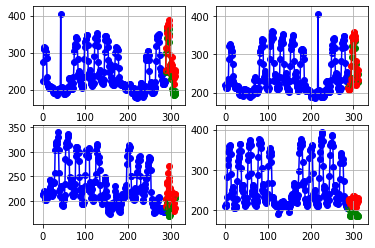

epoch = 0480, grad_step = 032708, tr_loss (epoch) = 1.060, te_loss (epoch) = 4.337
epoch = 0481, grad_step = 032776, tr_loss (epoch) = 0.994, te_loss (epoch) = 4.222
epoch = 0482, grad_step = 032844, tr_loss (epoch) = 0.958, te_loss (epoch) = 2.978
epoch = 0483, grad_step = 032912, tr_loss (epoch) = 0.967, te_loss (epoch) = 2.521
epoch = 0484, grad_step = 032980, tr_loss (epoch) = 0.958, te_loss (epoch) = 3.428
epoch = 0485, grad_step = 033048, tr_loss (epoch) = 1.012, te_loss (epoch) = 3.071
epoch = 0486, grad_step = 033116, tr_loss (epoch) = 0.992, te_loss (epoch) = 3.491
epoch = 0487, grad_step = 033184, tr_loss (epoch) = 0.999, te_loss (epoch) = 3.662
epoch = 0488, grad_step = 033252, tr_loss (epoch) = 1.246, te_loss (epoch) = 5.812
epoch = 0489, grad_step = 033320, tr_loss (epoch) = 1.122, te_loss (epoch) = 7.516


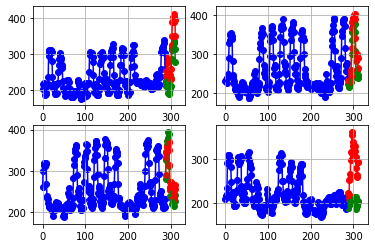

epoch = 0490, grad_step = 033388, tr_loss (epoch) = 1.160, te_loss (epoch) = 9.715
epoch = 0491, grad_step = 033456, tr_loss (epoch) = 1.138, te_loss (epoch) = 6.390
epoch = 0492, grad_step = 033524, tr_loss (epoch) = 1.045, te_loss (epoch) = 5.619
epoch = 0493, grad_step = 033592, tr_loss (epoch) = 0.918, te_loss (epoch) = 4.255
epoch = 0494, grad_step = 033660, tr_loss (epoch) = 0.912, te_loss (epoch) = 3.136
epoch = 0495, grad_step = 033728, tr_loss (epoch) = 0.893, te_loss (epoch) = 3.058
epoch = 0496, grad_step = 033796, tr_loss (epoch) = 0.903, te_loss (epoch) = 3.039
epoch = 0497, grad_step = 033864, tr_loss (epoch) = 0.880, te_loss (epoch) = 3.060
epoch = 0498, grad_step = 033932, tr_loss (epoch) = 0.872, te_loss (epoch) = 4.315
epoch = 0499, grad_step = 034000, tr_loss (epoch) = 0.898, te_loss (epoch) = 7.510


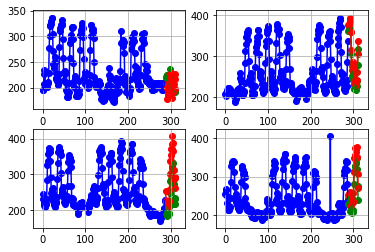

epoch = 0500, grad_step = 034068, tr_loss (epoch) = 0.937, te_loss (epoch) = 5.494
epoch = 0501, grad_step = 034136, tr_loss (epoch) = 0.807, te_loss (epoch) = 3.505
epoch = 0502, grad_step = 034204, tr_loss (epoch) = 0.799, te_loss (epoch) = 3.144
epoch = 0503, grad_step = 034272, tr_loss (epoch) = 0.855, te_loss (epoch) = 2.714
epoch = 0504, grad_step = 034340, tr_loss (epoch) = 0.903, te_loss (epoch) = 3.345
epoch = 0505, grad_step = 034408, tr_loss (epoch) = 0.956, te_loss (epoch) = 3.043
epoch = 0506, grad_step = 034476, tr_loss (epoch) = 0.953, te_loss (epoch) = 3.869
epoch = 0507, grad_step = 034544, tr_loss (epoch) = 0.939, te_loss (epoch) = 3.388
epoch = 0508, grad_step = 034612, tr_loss (epoch) = 0.952, te_loss (epoch) = 3.986
epoch = 0509, grad_step = 034680, tr_loss (epoch) = 0.935, te_loss (epoch) = 3.937


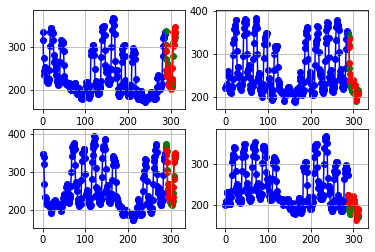

epoch = 0510, grad_step = 034748, tr_loss (epoch) = 0.917, te_loss (epoch) = 3.522
epoch = 0511, grad_step = 034816, tr_loss (epoch) = 0.887, te_loss (epoch) = 3.033
epoch = 0512, grad_step = 034884, tr_loss (epoch) = 0.928, te_loss (epoch) = 3.315
epoch = 0513, grad_step = 034952, tr_loss (epoch) = 0.924, te_loss (epoch) = 2.832
epoch = 0514, grad_step = 035020, tr_loss (epoch) = 0.931, te_loss (epoch) = 2.903
epoch = 0515, grad_step = 035088, tr_loss (epoch) = 0.947, te_loss (epoch) = 3.079
epoch = 0516, grad_step = 035156, tr_loss (epoch) = 0.947, te_loss (epoch) = 3.182
epoch = 0517, grad_step = 035224, tr_loss (epoch) = 1.068, te_loss (epoch) = 4.975
epoch = 0518, grad_step = 035292, tr_loss (epoch) = 1.162, te_loss (epoch) = 6.816
epoch = 0519, grad_step = 035360, tr_loss (epoch) = 1.459, te_loss (epoch) = 6.656


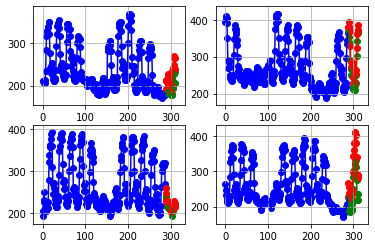

epoch = 0520, grad_step = 035428, tr_loss (epoch) = 1.505, te_loss (epoch) = 11.201
epoch = 0521, grad_step = 035496, tr_loss (epoch) = 1.725, te_loss (epoch) = 7.238
epoch = 0522, grad_step = 035564, tr_loss (epoch) = 1.556, te_loss (epoch) = 5.668
epoch = 0523, grad_step = 035632, tr_loss (epoch) = 1.546, te_loss (epoch) = 3.520
epoch = 0524, grad_step = 035700, tr_loss (epoch) = 1.232, te_loss (epoch) = 2.799
epoch = 0525, grad_step = 035768, tr_loss (epoch) = 1.269, te_loss (epoch) = 2.904
epoch = 0526, grad_step = 035836, tr_loss (epoch) = 1.008, te_loss (epoch) = 2.412
epoch = 0527, grad_step = 035904, tr_loss (epoch) = 0.948, te_loss (epoch) = 2.656
epoch = 0528, grad_step = 035972, tr_loss (epoch) = 0.849, te_loss (epoch) = 2.430
epoch = 0529, grad_step = 036040, tr_loss (epoch) = 0.843, te_loss (epoch) = 2.907


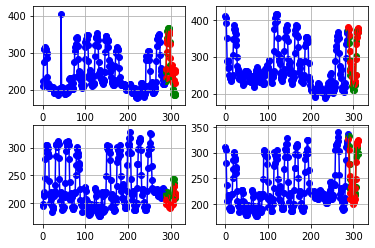

epoch = 0530, grad_step = 036108, tr_loss (epoch) = 0.795, te_loss (epoch) = 3.121
epoch = 0531, grad_step = 036176, tr_loss (epoch) = 0.786, te_loss (epoch) = 3.346
epoch = 0532, grad_step = 036244, tr_loss (epoch) = 0.769, te_loss (epoch) = 2.728
epoch = 0533, grad_step = 036312, tr_loss (epoch) = 0.791, te_loss (epoch) = 2.798
epoch = 0534, grad_step = 036380, tr_loss (epoch) = 0.827, te_loss (epoch) = 2.729
epoch = 0535, grad_step = 036448, tr_loss (epoch) = 0.853, te_loss (epoch) = 3.025
epoch = 0536, grad_step = 036516, tr_loss (epoch) = 0.881, te_loss (epoch) = 2.976
epoch = 0537, grad_step = 036584, tr_loss (epoch) = 0.932, te_loss (epoch) = 2.960
epoch = 0538, grad_step = 036652, tr_loss (epoch) = 0.948, te_loss (epoch) = 2.832
epoch = 0539, grad_step = 036720, tr_loss (epoch) = 0.946, te_loss (epoch) = 2.856


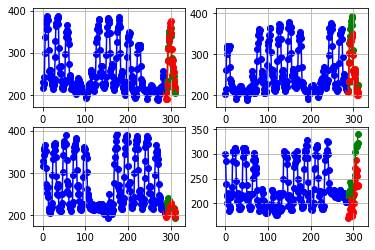

epoch = 0540, grad_step = 036788, tr_loss (epoch) = 0.975, te_loss (epoch) = 2.709
epoch = 0541, grad_step = 036856, tr_loss (epoch) = 1.051, te_loss (epoch) = 3.152
epoch = 0542, grad_step = 036924, tr_loss (epoch) = 1.031, te_loss (epoch) = 2.621
epoch = 0543, grad_step = 036992, tr_loss (epoch) = 0.956, te_loss (epoch) = 2.833
epoch = 0544, grad_step = 037060, tr_loss (epoch) = 0.922, te_loss (epoch) = 2.964
epoch = 0545, grad_step = 037128, tr_loss (epoch) = 0.934, te_loss (epoch) = 3.044
epoch = 0546, grad_step = 037196, tr_loss (epoch) = 0.942, te_loss (epoch) = 2.979
epoch = 0547, grad_step = 037264, tr_loss (epoch) = 0.986, te_loss (epoch) = 3.803
epoch = 0548, grad_step = 037332, tr_loss (epoch) = 0.993, te_loss (epoch) = 3.192
epoch = 0549, grad_step = 037400, tr_loss (epoch) = 1.023, te_loss (epoch) = 3.230


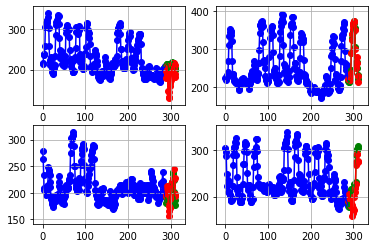

epoch = 0550, grad_step = 037468, tr_loss (epoch) = 1.009, te_loss (epoch) = 2.973
epoch = 0551, grad_step = 037536, tr_loss (epoch) = 1.000, te_loss (epoch) = 3.240
epoch = 0552, grad_step = 037604, tr_loss (epoch) = 1.017, te_loss (epoch) = 3.038
epoch = 0553, grad_step = 037672, tr_loss (epoch) = 0.985, te_loss (epoch) = 3.363
epoch = 0554, grad_step = 037740, tr_loss (epoch) = 1.048, te_loss (epoch) = 2.730
epoch = 0555, grad_step = 037808, tr_loss (epoch) = 1.015, te_loss (epoch) = 4.404
epoch = 0556, grad_step = 037876, tr_loss (epoch) = 1.048, te_loss (epoch) = 2.725
epoch = 0557, grad_step = 037944, tr_loss (epoch) = 1.111, te_loss (epoch) = 4.295
epoch = 0558, grad_step = 038012, tr_loss (epoch) = 1.036, te_loss (epoch) = 3.011
epoch = 0559, grad_step = 038080, tr_loss (epoch) = 1.045, te_loss (epoch) = 2.895


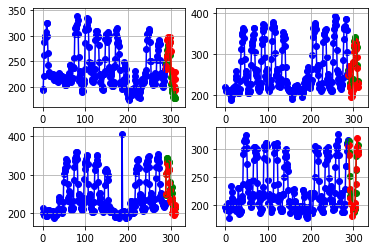

epoch = 0560, grad_step = 038148, tr_loss (epoch) = 0.932, te_loss (epoch) = 2.640
epoch = 0561, grad_step = 038216, tr_loss (epoch) = 0.977, te_loss (epoch) = 2.814
epoch = 0562, grad_step = 038284, tr_loss (epoch) = 1.014, te_loss (epoch) = 2.827
epoch = 0563, grad_step = 038352, tr_loss (epoch) = 1.013, te_loss (epoch) = 3.154
epoch = 0564, grad_step = 038420, tr_loss (epoch) = 1.004, te_loss (epoch) = 3.270
epoch = 0565, grad_step = 038488, tr_loss (epoch) = 1.014, te_loss (epoch) = 3.503
epoch = 0566, grad_step = 038556, tr_loss (epoch) = 1.005, te_loss (epoch) = 3.041
epoch = 0567, grad_step = 038624, tr_loss (epoch) = 0.958, te_loss (epoch) = 3.168
epoch = 0568, grad_step = 038692, tr_loss (epoch) = 0.922, te_loss (epoch) = 2.695
epoch = 0569, grad_step = 038760, tr_loss (epoch) = 0.865, te_loss (epoch) = 3.188


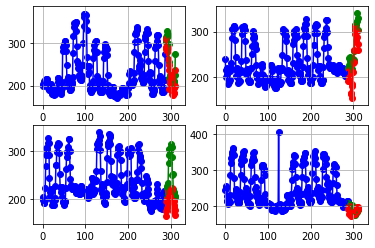

epoch = 0570, grad_step = 038828, tr_loss (epoch) = 0.856, te_loss (epoch) = 3.163
epoch = 0571, grad_step = 038896, tr_loss (epoch) = 0.859, te_loss (epoch) = 3.984
epoch = 0572, grad_step = 038964, tr_loss (epoch) = 0.879, te_loss (epoch) = 3.921
epoch = 0573, grad_step = 039032, tr_loss (epoch) = 0.899, te_loss (epoch) = 3.883
epoch = 0574, grad_step = 039100, tr_loss (epoch) = 0.902, te_loss (epoch) = 3.156
epoch = 0575, grad_step = 039168, tr_loss (epoch) = 0.912, te_loss (epoch) = 2.941
epoch = 0576, grad_step = 039236, tr_loss (epoch) = 0.921, te_loss (epoch) = 3.527
epoch = 0577, grad_step = 039304, tr_loss (epoch) = 1.093, te_loss (epoch) = 5.075
epoch = 0578, grad_step = 039372, tr_loss (epoch) = 1.134, te_loss (epoch) = 4.021
epoch = 0579, grad_step = 039440, tr_loss (epoch) = 1.096, te_loss (epoch) = 3.224


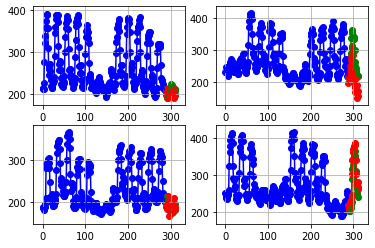

epoch = 0580, grad_step = 039508, tr_loss (epoch) = 1.096, te_loss (epoch) = 4.418
epoch = 0581, grad_step = 039576, tr_loss (epoch) = 1.012, te_loss (epoch) = 3.424
epoch = 0582, grad_step = 039644, tr_loss (epoch) = 0.971, te_loss (epoch) = 3.426
epoch = 0583, grad_step = 039712, tr_loss (epoch) = 0.988, te_loss (epoch) = 4.113
epoch = 0584, grad_step = 039780, tr_loss (epoch) = 0.964, te_loss (epoch) = 3.747
epoch = 0585, grad_step = 039848, tr_loss (epoch) = 0.983, te_loss (epoch) = 4.055
epoch = 0586, grad_step = 039916, tr_loss (epoch) = 1.031, te_loss (epoch) = 3.762
epoch = 0587, grad_step = 039984, tr_loss (epoch) = 1.017, te_loss (epoch) = 3.674
epoch = 0588, grad_step = 040052, tr_loss (epoch) = 0.933, te_loss (epoch) = 3.143
epoch = 0589, grad_step = 040120, tr_loss (epoch) = 0.962, te_loss (epoch) = 3.102


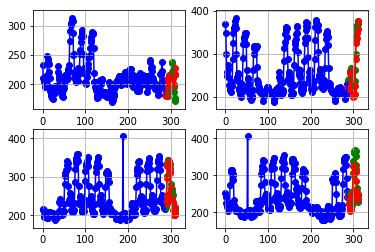

epoch = 0590, grad_step = 040188, tr_loss (epoch) = 0.889, te_loss (epoch) = 2.684
epoch = 0591, grad_step = 040256, tr_loss (epoch) = 0.866, te_loss (epoch) = 2.887
epoch = 0592, grad_step = 040324, tr_loss (epoch) = 0.847, te_loss (epoch) = 3.255
epoch = 0593, grad_step = 040392, tr_loss (epoch) = 0.832, te_loss (epoch) = 3.873
epoch = 0594, grad_step = 040460, tr_loss (epoch) = 0.850, te_loss (epoch) = 5.206
epoch = 0595, grad_step = 040528, tr_loss (epoch) = 0.983, te_loss (epoch) = 5.170
epoch = 0596, grad_step = 040596, tr_loss (epoch) = 0.992, te_loss (epoch) = 5.038
epoch = 0597, grad_step = 040664, tr_loss (epoch) = 0.941, te_loss (epoch) = 4.668
epoch = 0598, grad_step = 040732, tr_loss (epoch) = 0.872, te_loss (epoch) = 3.073
epoch = 0599, grad_step = 040800, tr_loss (epoch) = 0.802, te_loss (epoch) = 3.227


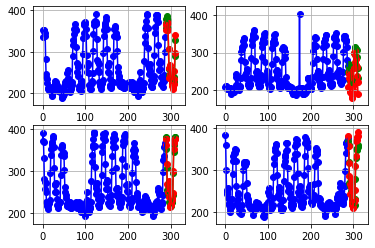

epoch = 0600, grad_step = 040868, tr_loss (epoch) = 0.773, te_loss (epoch) = 2.830
epoch = 0601, grad_step = 040936, tr_loss (epoch) = 0.758, te_loss (epoch) = 3.239
epoch = 0602, grad_step = 041004, tr_loss (epoch) = 0.755, te_loss (epoch) = 4.114
epoch = 0603, grad_step = 041072, tr_loss (epoch) = 0.799, te_loss (epoch) = 4.928
epoch = 0604, grad_step = 041140, tr_loss (epoch) = 0.837, te_loss (epoch) = 5.496
epoch = 0605, grad_step = 041208, tr_loss (epoch) = 0.942, te_loss (epoch) = 5.567
epoch = 0606, grad_step = 041276, tr_loss (epoch) = 1.153, te_loss (epoch) = 7.115
epoch = 0607, grad_step = 041344, tr_loss (epoch) = 1.225, te_loss (epoch) = 6.815
epoch = 0608, grad_step = 041412, tr_loss (epoch) = 1.136, te_loss (epoch) = 4.806
epoch = 0609, grad_step = 041480, tr_loss (epoch) = 0.990, te_loss (epoch) = 5.716


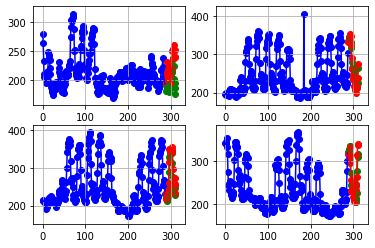

epoch = 0610, grad_step = 041548, tr_loss (epoch) = 0.948, te_loss (epoch) = 3.870
epoch = 0611, grad_step = 041616, tr_loss (epoch) = 0.939, te_loss (epoch) = 4.130
epoch = 0612, grad_step = 041684, tr_loss (epoch) = 0.915, te_loss (epoch) = 3.071
epoch = 0613, grad_step = 041752, tr_loss (epoch) = 0.866, te_loss (epoch) = 4.783
epoch = 0614, grad_step = 041820, tr_loss (epoch) = 0.865, te_loss (epoch) = 2.950
epoch = 0615, grad_step = 041888, tr_loss (epoch) = 0.790, te_loss (epoch) = 3.087
epoch = 0616, grad_step = 041956, tr_loss (epoch) = 0.745, te_loss (epoch) = 3.777
epoch = 0617, grad_step = 042024, tr_loss (epoch) = 0.766, te_loss (epoch) = 6.782
epoch = 0618, grad_step = 042092, tr_loss (epoch) = 0.892, te_loss (epoch) = 7.854
epoch = 0619, grad_step = 042160, tr_loss (epoch) = 1.067, te_loss (epoch) = 6.490


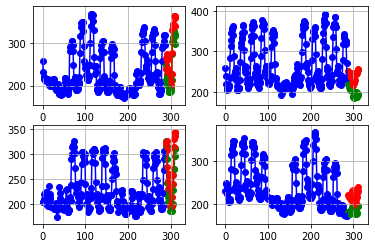

epoch = 0620, grad_step = 042228, tr_loss (epoch) = 1.106, te_loss (epoch) = 6.353
epoch = 0621, grad_step = 042296, tr_loss (epoch) = 0.986, te_loss (epoch) = 5.208
epoch = 0622, grad_step = 042364, tr_loss (epoch) = 0.921, te_loss (epoch) = 4.120
epoch = 0623, grad_step = 042432, tr_loss (epoch) = 0.858, te_loss (epoch) = 4.751
epoch = 0624, grad_step = 042500, tr_loss (epoch) = 0.812, te_loss (epoch) = 5.215
epoch = 0625, grad_step = 042568, tr_loss (epoch) = 0.822, te_loss (epoch) = 5.054
epoch = 0626, grad_step = 042636, tr_loss (epoch) = 0.838, te_loss (epoch) = 4.781
epoch = 0627, grad_step = 042704, tr_loss (epoch) = 0.830, te_loss (epoch) = 4.500
epoch = 0628, grad_step = 042772, tr_loss (epoch) = 0.778, te_loss (epoch) = 4.422
epoch = 0629, grad_step = 042840, tr_loss (epoch) = 0.768, te_loss (epoch) = 3.867


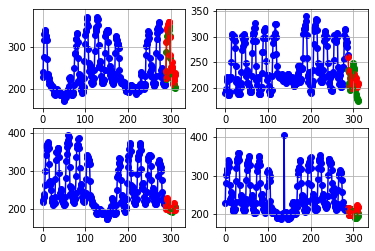

epoch = 0630, grad_step = 042908, tr_loss (epoch) = 0.756, te_loss (epoch) = 3.456
epoch = 0631, grad_step = 042976, tr_loss (epoch) = 0.744, te_loss (epoch) = 3.364
epoch = 0632, grad_step = 043044, tr_loss (epoch) = 0.719, te_loss (epoch) = 3.596
epoch = 0633, grad_step = 043112, tr_loss (epoch) = 0.722, te_loss (epoch) = 4.317
epoch = 0634, grad_step = 043180, tr_loss (epoch) = 0.716, te_loss (epoch) = 5.391
epoch = 0635, grad_step = 043248, tr_loss (epoch) = 0.742, te_loss (epoch) = 4.829
epoch = 0636, grad_step = 043316, tr_loss (epoch) = 0.738, te_loss (epoch) = 4.059
epoch = 0637, grad_step = 043384, tr_loss (epoch) = 0.759, te_loss (epoch) = 3.898
epoch = 0638, grad_step = 043452, tr_loss (epoch) = 0.771, te_loss (epoch) = 3.499
epoch = 0639, grad_step = 043520, tr_loss (epoch) = 0.750, te_loss (epoch) = 3.284


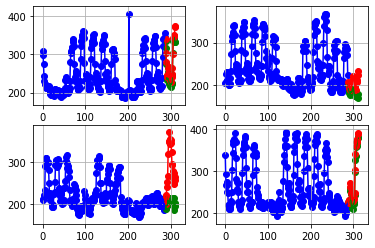

epoch = 0640, grad_step = 043588, tr_loss (epoch) = 0.749, te_loss (epoch) = 4.559
epoch = 0641, grad_step = 043656, tr_loss (epoch) = 0.738, te_loss (epoch) = 5.295
epoch = 0642, grad_step = 043724, tr_loss (epoch) = 0.726, te_loss (epoch) = 5.518
epoch = 0643, grad_step = 043792, tr_loss (epoch) = 0.737, te_loss (epoch) = 3.397
epoch = 0644, grad_step = 043860, tr_loss (epoch) = 0.783, te_loss (epoch) = 2.960
epoch = 0645, grad_step = 043928, tr_loss (epoch) = 0.797, te_loss (epoch) = 3.021
epoch = 0646, grad_step = 043996, tr_loss (epoch) = 0.829, te_loss (epoch) = 2.814
epoch = 0647, grad_step = 044064, tr_loss (epoch) = 0.874, te_loss (epoch) = 3.857
epoch = 0648, grad_step = 044132, tr_loss (epoch) = 0.938, te_loss (epoch) = 4.383
epoch = 0649, grad_step = 044200, tr_loss (epoch) = 0.961, te_loss (epoch) = 4.236


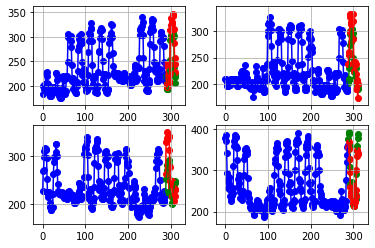

epoch = 0650, grad_step = 044268, tr_loss (epoch) = 0.933, te_loss (epoch) = 3.919
epoch = 0651, grad_step = 044336, tr_loss (epoch) = 0.924, te_loss (epoch) = 4.791
epoch = 0652, grad_step = 044404, tr_loss (epoch) = 0.934, te_loss (epoch) = 7.119
epoch = 0653, grad_step = 044472, tr_loss (epoch) = 0.990, te_loss (epoch) = 6.972
epoch = 0654, grad_step = 044540, tr_loss (epoch) = 0.863, te_loss (epoch) = 5.795
epoch = 0655, grad_step = 044608, tr_loss (epoch) = 0.865, te_loss (epoch) = 4.110
epoch = 0656, grad_step = 044676, tr_loss (epoch) = 0.824, te_loss (epoch) = 2.772
epoch = 0657, grad_step = 044744, tr_loss (epoch) = 0.833, te_loss (epoch) = 3.757
epoch = 0658, grad_step = 044812, tr_loss (epoch) = 0.884, te_loss (epoch) = 2.862
epoch = 0659, grad_step = 044880, tr_loss (epoch) = 0.942, te_loss (epoch) = 3.159


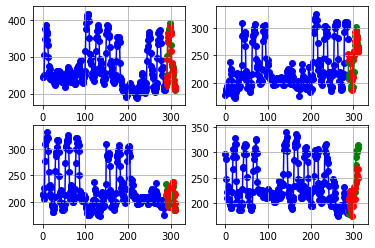

epoch = 0660, grad_step = 044948, tr_loss (epoch) = 0.959, te_loss (epoch) = 3.193
epoch = 0661, grad_step = 045016, tr_loss (epoch) = 0.874, te_loss (epoch) = 4.837
epoch = 0662, grad_step = 045084, tr_loss (epoch) = 0.795, te_loss (epoch) = 5.013
epoch = 0663, grad_step = 045152, tr_loss (epoch) = 0.743, te_loss (epoch) = 3.092
epoch = 0664, grad_step = 045220, tr_loss (epoch) = 0.707, te_loss (epoch) = 2.812
epoch = 0665, grad_step = 045288, tr_loss (epoch) = 0.773, te_loss (epoch) = 2.785
epoch = 0666, grad_step = 045356, tr_loss (epoch) = 0.767, te_loss (epoch) = 2.678
epoch = 0667, grad_step = 045424, tr_loss (epoch) = 0.742, te_loss (epoch) = 2.990
epoch = 0668, grad_step = 045492, tr_loss (epoch) = 0.680, te_loss (epoch) = 3.112
epoch = 0669, grad_step = 045560, tr_loss (epoch) = 0.666, te_loss (epoch) = 2.877


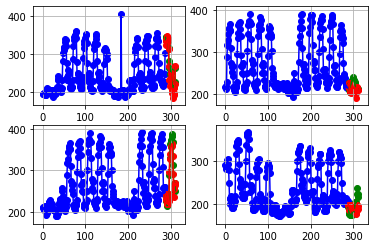

epoch = 0670, grad_step = 045628, tr_loss (epoch) = 0.660, te_loss (epoch) = 2.441
epoch = 0671, grad_step = 045696, tr_loss (epoch) = 0.681, te_loss (epoch) = 3.006
epoch = 0672, grad_step = 045764, tr_loss (epoch) = 0.749, te_loss (epoch) = 2.913
epoch = 0673, grad_step = 045832, tr_loss (epoch) = 0.763, te_loss (epoch) = 3.414
epoch = 0674, grad_step = 045900, tr_loss (epoch) = 0.795, te_loss (epoch) = 3.232
epoch = 0675, grad_step = 045968, tr_loss (epoch) = 0.775, te_loss (epoch) = 2.941
epoch = 0676, grad_step = 046036, tr_loss (epoch) = 0.743, te_loss (epoch) = 2.844
epoch = 0677, grad_step = 046104, tr_loss (epoch) = 0.735, te_loss (epoch) = 2.894
epoch = 0678, grad_step = 046172, tr_loss (epoch) = 0.732, te_loss (epoch) = 2.913
epoch = 0679, grad_step = 046240, tr_loss (epoch) = 0.709, te_loss (epoch) = 2.767


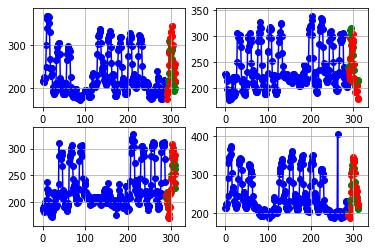

epoch = 0680, grad_step = 046308, tr_loss (epoch) = 0.669, te_loss (epoch) = 2.707
epoch = 0681, grad_step = 046376, tr_loss (epoch) = 0.671, te_loss (epoch) = 3.419
epoch = 0682, grad_step = 046444, tr_loss (epoch) = 0.689, te_loss (epoch) = 3.200
epoch = 0683, grad_step = 046512, tr_loss (epoch) = 0.702, te_loss (epoch) = 3.468
epoch = 0684, grad_step = 046580, tr_loss (epoch) = 0.742, te_loss (epoch) = 3.161
epoch = 0685, grad_step = 046648, tr_loss (epoch) = 0.807, te_loss (epoch) = 4.675
epoch = 0686, grad_step = 046716, tr_loss (epoch) = 0.895, te_loss (epoch) = 6.678
epoch = 0687, grad_step = 046784, tr_loss (epoch) = 1.088, te_loss (epoch) = 5.692
epoch = 0688, grad_step = 046852, tr_loss (epoch) = 1.197, te_loss (epoch) = 5.122
epoch = 0689, grad_step = 046920, tr_loss (epoch) = 1.071, te_loss (epoch) = 2.888


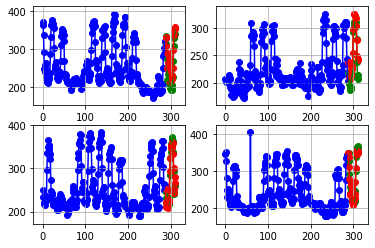

epoch = 0690, grad_step = 046988, tr_loss (epoch) = 0.851, te_loss (epoch) = 3.762
epoch = 0691, grad_step = 047056, tr_loss (epoch) = 0.739, te_loss (epoch) = 2.691
epoch = 0692, grad_step = 047124, tr_loss (epoch) = 0.670, te_loss (epoch) = 2.709
epoch = 0693, grad_step = 047192, tr_loss (epoch) = 0.623, te_loss (epoch) = 2.972
epoch = 0694, grad_step = 047260, tr_loss (epoch) = 0.626, te_loss (epoch) = 3.787
epoch = 0695, grad_step = 047328, tr_loss (epoch) = 0.664, te_loss (epoch) = 4.074
epoch = 0696, grad_step = 047396, tr_loss (epoch) = 0.707, te_loss (epoch) = 4.045
epoch = 0697, grad_step = 047464, tr_loss (epoch) = 0.710, te_loss (epoch) = 3.390
epoch = 0698, grad_step = 047532, tr_loss (epoch) = 0.688, te_loss (epoch) = 3.165
epoch = 0699, grad_step = 047600, tr_loss (epoch) = 0.678, te_loss (epoch) = 3.085


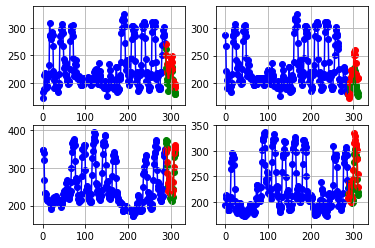

epoch = 0700, grad_step = 047668, tr_loss (epoch) = 0.683, te_loss (epoch) = 3.651
epoch = 0701, grad_step = 047736, tr_loss (epoch) = 0.706, te_loss (epoch) = 3.981
epoch = 0702, grad_step = 047804, tr_loss (epoch) = 0.731, te_loss (epoch) = 4.346
epoch = 0703, grad_step = 047872, tr_loss (epoch) = 0.722, te_loss (epoch) = 5.432
epoch = 0704, grad_step = 047940, tr_loss (epoch) = 0.817, te_loss (epoch) = 4.965
epoch = 0705, grad_step = 048008, tr_loss (epoch) = 0.801, te_loss (epoch) = 4.919
epoch = 0706, grad_step = 048076, tr_loss (epoch) = 0.786, te_loss (epoch) = 3.384
epoch = 0707, grad_step = 048144, tr_loss (epoch) = 0.726, te_loss (epoch) = 3.667
epoch = 0708, grad_step = 048212, tr_loss (epoch) = 0.682, te_loss (epoch) = 4.011
epoch = 0709, grad_step = 048280, tr_loss (epoch) = 0.657, te_loss (epoch) = 3.523


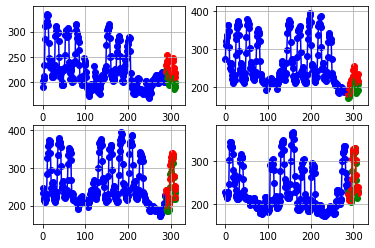

epoch = 0710, grad_step = 048348, tr_loss (epoch) = 0.637, te_loss (epoch) = 3.261
epoch = 0711, grad_step = 048416, tr_loss (epoch) = 0.658, te_loss (epoch) = 3.247
epoch = 0712, grad_step = 048484, tr_loss (epoch) = 0.681, te_loss (epoch) = 3.600
epoch = 0713, grad_step = 048552, tr_loss (epoch) = 0.690, te_loss (epoch) = 4.972
epoch = 0714, grad_step = 048620, tr_loss (epoch) = 0.692, te_loss (epoch) = 6.167
epoch = 0715, grad_step = 048688, tr_loss (epoch) = 0.702, te_loss (epoch) = 4.415
epoch = 0716, grad_step = 048756, tr_loss (epoch) = 0.720, te_loss (epoch) = 3.462
epoch = 0717, grad_step = 048824, tr_loss (epoch) = 0.726, te_loss (epoch) = 3.140
epoch = 0718, grad_step = 048892, tr_loss (epoch) = 0.750, te_loss (epoch) = 2.612
epoch = 0719, grad_step = 048960, tr_loss (epoch) = 0.756, te_loss (epoch) = 2.996


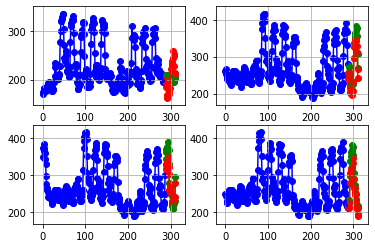

epoch = 0720, grad_step = 049028, tr_loss (epoch) = 0.775, te_loss (epoch) = 3.303
epoch = 0721, grad_step = 049096, tr_loss (epoch) = 0.764, te_loss (epoch) = 2.969
epoch = 0722, grad_step = 049164, tr_loss (epoch) = 0.723, te_loss (epoch) = 3.367
epoch = 0723, grad_step = 049232, tr_loss (epoch) = 0.669, te_loss (epoch) = 3.742
epoch = 0724, grad_step = 049300, tr_loss (epoch) = 0.677, te_loss (epoch) = 3.341
epoch = 0725, grad_step = 049368, tr_loss (epoch) = 0.649, te_loss (epoch) = 2.370
epoch = 0726, grad_step = 049436, tr_loss (epoch) = 0.643, te_loss (epoch) = 3.365
epoch = 0727, grad_step = 049504, tr_loss (epoch) = 0.742, te_loss (epoch) = 3.599
epoch = 0728, grad_step = 049572, tr_loss (epoch) = 0.820, te_loss (epoch) = 4.459
epoch = 0729, grad_step = 049640, tr_loss (epoch) = 0.815, te_loss (epoch) = 2.898


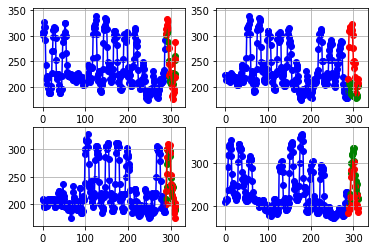

epoch = 0730, grad_step = 049708, tr_loss (epoch) = 0.763, te_loss (epoch) = 3.132
epoch = 0731, grad_step = 049776, tr_loss (epoch) = 0.736, te_loss (epoch) = 3.402
epoch = 0732, grad_step = 049844, tr_loss (epoch) = 0.770, te_loss (epoch) = 5.048
epoch = 0733, grad_step = 049912, tr_loss (epoch) = 0.784, te_loss (epoch) = 3.874
epoch = 0734, grad_step = 049980, tr_loss (epoch) = 0.774, te_loss (epoch) = 2.895
epoch = 0735, grad_step = 050048, tr_loss (epoch) = 0.706, te_loss (epoch) = 3.033
epoch = 0736, grad_step = 050116, tr_loss (epoch) = 0.730, te_loss (epoch) = 3.137
epoch = 0737, grad_step = 050184, tr_loss (epoch) = 0.767, te_loss (epoch) = 2.843
epoch = 0738, grad_step = 050252, tr_loss (epoch) = 0.782, te_loss (epoch) = 3.306
epoch = 0739, grad_step = 050320, tr_loss (epoch) = 0.808, te_loss (epoch) = 5.909


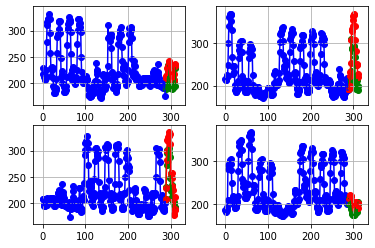

epoch = 0740, grad_step = 050388, tr_loss (epoch) = 0.896, te_loss (epoch) = 5.228
epoch = 0741, grad_step = 050456, tr_loss (epoch) = 0.942, te_loss (epoch) = 4.081
epoch = 0742, grad_step = 050524, tr_loss (epoch) = 0.777, te_loss (epoch) = 3.295
epoch = 0743, grad_step = 050592, tr_loss (epoch) = 0.659, te_loss (epoch) = 2.576
epoch = 0744, grad_step = 050660, tr_loss (epoch) = 0.632, te_loss (epoch) = 2.564
epoch = 0745, grad_step = 050728, tr_loss (epoch) = 0.624, te_loss (epoch) = 2.974
epoch = 0746, grad_step = 050796, tr_loss (epoch) = 0.618, te_loss (epoch) = 3.891
epoch = 0747, grad_step = 050864, tr_loss (epoch) = 0.637, te_loss (epoch) = 4.114
epoch = 0748, grad_step = 050932, tr_loss (epoch) = 0.664, te_loss (epoch) = 3.494
epoch = 0749, grad_step = 051000, tr_loss (epoch) = 0.636, te_loss (epoch) = 3.177


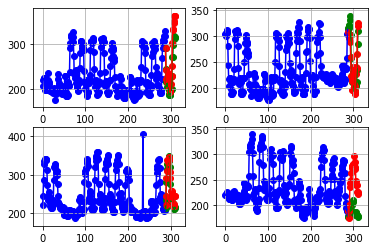

epoch = 0750, grad_step = 051068, tr_loss (epoch) = 0.622, te_loss (epoch) = 3.109
epoch = 0751, grad_step = 051136, tr_loss (epoch) = 0.613, te_loss (epoch) = 4.484
epoch = 0752, grad_step = 051204, tr_loss (epoch) = 0.623, te_loss (epoch) = 4.588
epoch = 0753, grad_step = 051272, tr_loss (epoch) = 0.676, te_loss (epoch) = 3.756
epoch = 0754, grad_step = 051340, tr_loss (epoch) = 0.658, te_loss (epoch) = 2.749
epoch = 0755, grad_step = 051408, tr_loss (epoch) = 0.648, te_loss (epoch) = 2.962
epoch = 0756, grad_step = 051476, tr_loss (epoch) = 0.661, te_loss (epoch) = 2.966
epoch = 0757, grad_step = 051544, tr_loss (epoch) = 0.663, te_loss (epoch) = 3.733
epoch = 0758, grad_step = 051612, tr_loss (epoch) = 0.656, te_loss (epoch) = 3.181
epoch = 0759, grad_step = 051680, tr_loss (epoch) = 0.697, te_loss (epoch) = 2.886


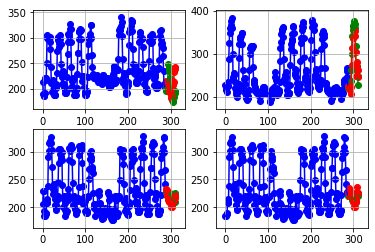

epoch = 0760, grad_step = 051748, tr_loss (epoch) = 0.681, te_loss (epoch) = 3.343
epoch = 0761, grad_step = 051816, tr_loss (epoch) = 0.698, te_loss (epoch) = 3.963
epoch = 0762, grad_step = 051884, tr_loss (epoch) = 0.646, te_loss (epoch) = 3.358
epoch = 0763, grad_step = 051952, tr_loss (epoch) = 0.639, te_loss (epoch) = 2.840
epoch = 0764, grad_step = 052020, tr_loss (epoch) = 0.629, te_loss (epoch) = 2.691
epoch = 0765, grad_step = 052088, tr_loss (epoch) = 0.641, te_loss (epoch) = 3.293
epoch = 0766, grad_step = 052156, tr_loss (epoch) = 0.711, te_loss (epoch) = 3.406
epoch = 0767, grad_step = 052224, tr_loss (epoch) = 0.704, te_loss (epoch) = 2.814
epoch = 0768, grad_step = 052292, tr_loss (epoch) = 0.714, te_loss (epoch) = 3.306
epoch = 0769, grad_step = 052360, tr_loss (epoch) = 0.740, te_loss (epoch) = 5.816


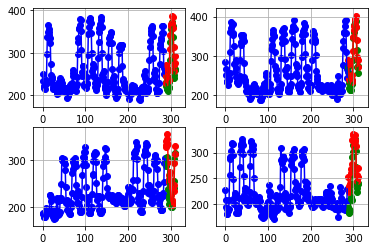

epoch = 0770, grad_step = 052428, tr_loss (epoch) = 0.866, te_loss (epoch) = 5.838
epoch = 0771, grad_step = 052496, tr_loss (epoch) = 0.863, te_loss (epoch) = 4.150
epoch = 0772, grad_step = 052564, tr_loss (epoch) = 0.828, te_loss (epoch) = 3.382
epoch = 0773, grad_step = 052632, tr_loss (epoch) = 0.716, te_loss (epoch) = 2.800
epoch = 0774, grad_step = 052700, tr_loss (epoch) = 0.652, te_loss (epoch) = 2.612
epoch = 0775, grad_step = 052768, tr_loss (epoch) = 0.642, te_loss (epoch) = 2.532
epoch = 0776, grad_step = 052836, tr_loss (epoch) = 0.611, te_loss (epoch) = 3.083
epoch = 0777, grad_step = 052904, tr_loss (epoch) = 0.596, te_loss (epoch) = 3.461
epoch = 0778, grad_step = 052972, tr_loss (epoch) = 0.625, te_loss (epoch) = 2.991
epoch = 0779, grad_step = 053040, tr_loss (epoch) = 0.593, te_loss (epoch) = 2.731


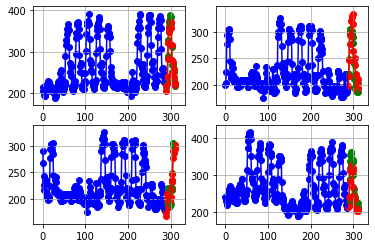

epoch = 0780, grad_step = 053108, tr_loss (epoch) = 0.606, te_loss (epoch) = 2.450
epoch = 0781, grad_step = 053176, tr_loss (epoch) = 0.593, te_loss (epoch) = 3.001
epoch = 0782, grad_step = 053244, tr_loss (epoch) = 0.583, te_loss (epoch) = 4.399
epoch = 0783, grad_step = 053312, tr_loss (epoch) = 0.634, te_loss (epoch) = 3.985
epoch = 0784, grad_step = 053380, tr_loss (epoch) = 0.644, te_loss (epoch) = 3.049
epoch = 0785, grad_step = 053448, tr_loss (epoch) = 0.602, te_loss (epoch) = 2.647
epoch = 0786, grad_step = 053516, tr_loss (epoch) = 0.590, te_loss (epoch) = 2.417
epoch = 0787, grad_step = 053584, tr_loss (epoch) = 0.604, te_loss (epoch) = 3.682
epoch = 0788, grad_step = 053652, tr_loss (epoch) = 0.612, te_loss (epoch) = 4.087
epoch = 0789, grad_step = 053720, tr_loss (epoch) = 0.622, te_loss (epoch) = 3.591


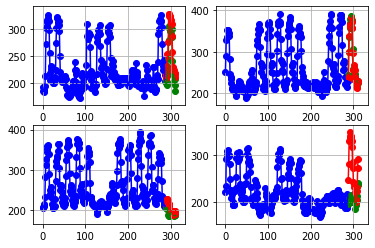

epoch = 0790, grad_step = 053788, tr_loss (epoch) = 0.616, te_loss (epoch) = 3.148
epoch = 0791, grad_step = 053856, tr_loss (epoch) = 0.640, te_loss (epoch) = 2.827
epoch = 0792, grad_step = 053924, tr_loss (epoch) = 0.628, te_loss (epoch) = 3.204
epoch = 0793, grad_step = 053992, tr_loss (epoch) = 0.649, te_loss (epoch) = 4.214
epoch = 0794, grad_step = 054060, tr_loss (epoch) = 0.618, te_loss (epoch) = 4.317
epoch = 0795, grad_step = 054128, tr_loss (epoch) = 0.622, te_loss (epoch) = 3.306
epoch = 0796, grad_step = 054196, tr_loss (epoch) = 0.613, te_loss (epoch) = 2.967
epoch = 0797, grad_step = 054264, tr_loss (epoch) = 0.631, te_loss (epoch) = 2.584
epoch = 0798, grad_step = 054332, tr_loss (epoch) = 0.623, te_loss (epoch) = 2.868
epoch = 0799, grad_step = 054400, tr_loss (epoch) = 0.614, te_loss (epoch) = 3.756


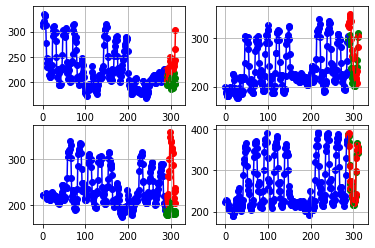

epoch = 0800, grad_step = 054468, tr_loss (epoch) = 0.598, te_loss (epoch) = 4.085
epoch = 0801, grad_step = 054536, tr_loss (epoch) = 0.588, te_loss (epoch) = 3.401
epoch = 0802, grad_step = 054604, tr_loss (epoch) = 0.592, te_loss (epoch) = 3.259
epoch = 0803, grad_step = 054672, tr_loss (epoch) = 0.602, te_loss (epoch) = 2.546
epoch = 0804, grad_step = 054740, tr_loss (epoch) = 0.608, te_loss (epoch) = 2.740
epoch = 0805, grad_step = 054808, tr_loss (epoch) = 0.634, te_loss (epoch) = 3.395
epoch = 0806, grad_step = 054876, tr_loss (epoch) = 0.643, te_loss (epoch) = 2.853
epoch = 0807, grad_step = 054944, tr_loss (epoch) = 0.585, te_loss (epoch) = 2.765
epoch = 0808, grad_step = 055012, tr_loss (epoch) = 0.562, te_loss (epoch) = 2.470
epoch = 0809, grad_step = 055080, tr_loss (epoch) = 0.551, te_loss (epoch) = 2.554


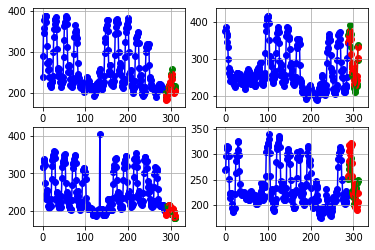

epoch = 0810, grad_step = 055148, tr_loss (epoch) = 0.548, te_loss (epoch) = 2.704
epoch = 0811, grad_step = 055216, tr_loss (epoch) = 0.559, te_loss (epoch) = 2.915
epoch = 0812, grad_step = 055284, tr_loss (epoch) = 0.565, te_loss (epoch) = 2.756
epoch = 0813, grad_step = 055352, tr_loss (epoch) = 0.570, te_loss (epoch) = 3.119
epoch = 0814, grad_step = 055420, tr_loss (epoch) = 0.586, te_loss (epoch) = 3.140
epoch = 0815, grad_step = 055488, tr_loss (epoch) = 0.644, te_loss (epoch) = 4.513
epoch = 0816, grad_step = 055556, tr_loss (epoch) = 0.695, te_loss (epoch) = 3.495
epoch = 0817, grad_step = 055624, tr_loss (epoch) = 0.703, te_loss (epoch) = 3.901
epoch = 0818, grad_step = 055692, tr_loss (epoch) = 0.807, te_loss (epoch) = 3.618
epoch = 0819, grad_step = 055760, tr_loss (epoch) = 0.909, te_loss (epoch) = 4.220


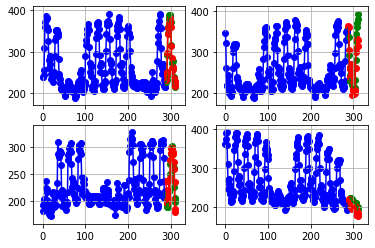

epoch = 0820, grad_step = 055828, tr_loss (epoch) = 0.894, te_loss (epoch) = 5.151
epoch = 0821, grad_step = 055896, tr_loss (epoch) = 0.822, te_loss (epoch) = 4.266
epoch = 0822, grad_step = 055964, tr_loss (epoch) = 0.768, te_loss (epoch) = 5.905
epoch = 0823, grad_step = 056032, tr_loss (epoch) = 0.834, te_loss (epoch) = 5.086
epoch = 0824, grad_step = 056100, tr_loss (epoch) = 0.794, te_loss (epoch) = 3.760
epoch = 0825, grad_step = 056168, tr_loss (epoch) = 0.708, te_loss (epoch) = 2.931
epoch = 0826, grad_step = 056236, tr_loss (epoch) = 0.629, te_loss (epoch) = 2.634
epoch = 0827, grad_step = 056304, tr_loss (epoch) = 0.613, te_loss (epoch) = 3.043
epoch = 0828, grad_step = 056372, tr_loss (epoch) = 0.600, te_loss (epoch) = 2.501
epoch = 0829, grad_step = 056440, tr_loss (epoch) = 0.561, te_loss (epoch) = 3.344


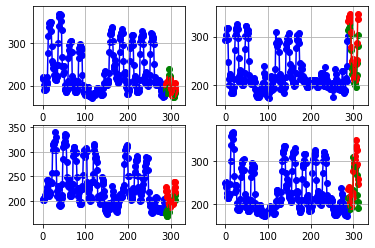

epoch = 0830, grad_step = 056508, tr_loss (epoch) = 0.574, te_loss (epoch) = 3.906
epoch = 0831, grad_step = 056576, tr_loss (epoch) = 0.619, te_loss (epoch) = 3.373
epoch = 0832, grad_step = 056644, tr_loss (epoch) = 0.586, te_loss (epoch) = 2.869
epoch = 0833, grad_step = 056712, tr_loss (epoch) = 0.555, te_loss (epoch) = 2.956
epoch = 0834, grad_step = 056780, tr_loss (epoch) = 0.538, te_loss (epoch) = 3.316
epoch = 0835, grad_step = 056848, tr_loss (epoch) = 0.550, te_loss (epoch) = 4.257
epoch = 0836, grad_step = 056916, tr_loss (epoch) = 0.589, te_loss (epoch) = 4.902
epoch = 0837, grad_step = 056984, tr_loss (epoch) = 0.632, te_loss (epoch) = 4.219
epoch = 0838, grad_step = 057052, tr_loss (epoch) = 0.634, te_loss (epoch) = 3.699
epoch = 0839, grad_step = 057120, tr_loss (epoch) = 0.645, te_loss (epoch) = 3.423


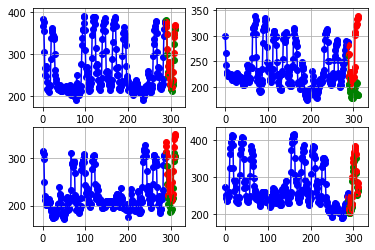

epoch = 0840, grad_step = 057188, tr_loss (epoch) = 0.614, te_loss (epoch) = 3.234
epoch = 0841, grad_step = 057256, tr_loss (epoch) = 0.588, te_loss (epoch) = 3.505
epoch = 0842, grad_step = 057324, tr_loss (epoch) = 0.561, te_loss (epoch) = 2.892
epoch = 0843, grad_step = 057392, tr_loss (epoch) = 0.567, te_loss (epoch) = 3.248
epoch = 0844, grad_step = 057460, tr_loss (epoch) = 0.564, te_loss (epoch) = 3.555
epoch = 0845, grad_step = 057528, tr_loss (epoch) = 0.554, te_loss (epoch) = 3.240
epoch = 0846, grad_step = 057596, tr_loss (epoch) = 0.576, te_loss (epoch) = 2.474
epoch = 0847, grad_step = 057664, tr_loss (epoch) = 0.604, te_loss (epoch) = 3.908
epoch = 0848, grad_step = 057732, tr_loss (epoch) = 0.742, te_loss (epoch) = 3.755
epoch = 0849, grad_step = 057800, tr_loss (epoch) = 0.789, te_loss (epoch) = 4.953


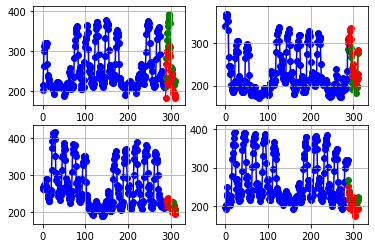

epoch = 0850, grad_step = 057868, tr_loss (epoch) = 0.770, te_loss (epoch) = 2.966
epoch = 0851, grad_step = 057936, tr_loss (epoch) = 0.752, te_loss (epoch) = 2.823
epoch = 0852, grad_step = 058004, tr_loss (epoch) = 0.700, te_loss (epoch) = 3.531
epoch = 0853, grad_step = 058072, tr_loss (epoch) = 0.698, te_loss (epoch) = 4.091
epoch = 0854, grad_step = 058140, tr_loss (epoch) = 0.693, te_loss (epoch) = 3.076
epoch = 0855, grad_step = 058208, tr_loss (epoch) = 0.619, te_loss (epoch) = 2.989
epoch = 0856, grad_step = 058276, tr_loss (epoch) = 0.639, te_loss (epoch) = 2.592
epoch = 0857, grad_step = 058344, tr_loss (epoch) = 0.695, te_loss (epoch) = 3.327
epoch = 0858, grad_step = 058412, tr_loss (epoch) = 0.680, te_loss (epoch) = 3.399
epoch = 0859, grad_step = 058480, tr_loss (epoch) = 0.680, te_loss (epoch) = 3.383


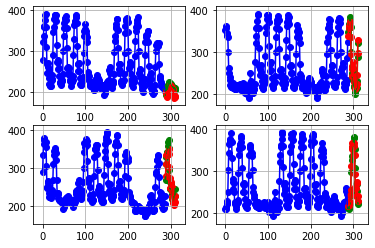

epoch = 0860, grad_step = 058548, tr_loss (epoch) = 0.613, te_loss (epoch) = 3.265
epoch = 0861, grad_step = 058616, tr_loss (epoch) = 0.581, te_loss (epoch) = 3.064
epoch = 0862, grad_step = 058684, tr_loss (epoch) = 0.544, te_loss (epoch) = 2.996
epoch = 0863, grad_step = 058752, tr_loss (epoch) = 0.541, te_loss (epoch) = 3.319
epoch = 0864, grad_step = 058820, tr_loss (epoch) = 0.538, te_loss (epoch) = 3.478
epoch = 0865, grad_step = 058888, tr_loss (epoch) = 0.554, te_loss (epoch) = 3.076
epoch = 0866, grad_step = 058956, tr_loss (epoch) = 0.531, te_loss (epoch) = 2.736
epoch = 0867, grad_step = 059024, tr_loss (epoch) = 0.527, te_loss (epoch) = 2.938
epoch = 0868, grad_step = 059092, tr_loss (epoch) = 0.513, te_loss (epoch) = 2.991
epoch = 0869, grad_step = 059160, tr_loss (epoch) = 0.503, te_loss (epoch) = 2.789


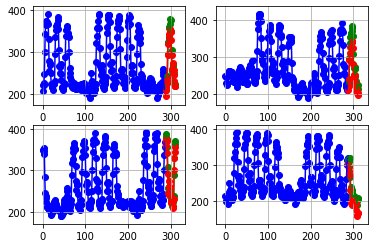

epoch = 0870, grad_step = 059228, tr_loss (epoch) = 0.494, te_loss (epoch) = 2.625
epoch = 0871, grad_step = 059296, tr_loss (epoch) = 0.516, te_loss (epoch) = 2.684
epoch = 0872, grad_step = 059364, tr_loss (epoch) = 0.518, te_loss (epoch) = 2.577
epoch = 0873, grad_step = 059432, tr_loss (epoch) = 0.524, te_loss (epoch) = 2.777
epoch = 0874, grad_step = 059500, tr_loss (epoch) = 0.514, te_loss (epoch) = 2.616
epoch = 0875, grad_step = 059568, tr_loss (epoch) = 0.506, te_loss (epoch) = 2.850
epoch = 0876, grad_step = 059636, tr_loss (epoch) = 0.513, te_loss (epoch) = 2.735
epoch = 0877, grad_step = 059704, tr_loss (epoch) = 0.529, te_loss (epoch) = 3.153
epoch = 0878, grad_step = 059772, tr_loss (epoch) = 0.536, te_loss (epoch) = 2.988
epoch = 0879, grad_step = 059840, tr_loss (epoch) = 0.549, te_loss (epoch) = 3.545


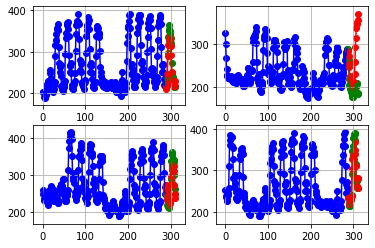

epoch = 0880, grad_step = 059908, tr_loss (epoch) = 0.575, te_loss (epoch) = 3.681
epoch = 0881, grad_step = 059976, tr_loss (epoch) = 0.612, te_loss (epoch) = 5.098
epoch = 0882, grad_step = 060044, tr_loss (epoch) = 0.676, te_loss (epoch) = 5.303
epoch = 0883, grad_step = 060112, tr_loss (epoch) = 0.733, te_loss (epoch) = 5.510
epoch = 0884, grad_step = 060180, tr_loss (epoch) = 0.936, te_loss (epoch) = 4.615
epoch = 0885, grad_step = 060248, tr_loss (epoch) = 0.885, te_loss (epoch) = 4.132
epoch = 0886, grad_step = 060316, tr_loss (epoch) = 0.749, te_loss (epoch) = 3.682
epoch = 0887, grad_step = 060384, tr_loss (epoch) = 0.688, te_loss (epoch) = 3.321
epoch = 0888, grad_step = 060452, tr_loss (epoch) = 0.655, te_loss (epoch) = 3.358
epoch = 0889, grad_step = 060520, tr_loss (epoch) = 0.636, te_loss (epoch) = 3.254


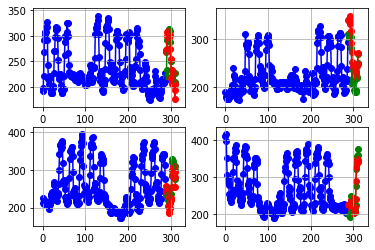

epoch = 0890, grad_step = 060588, tr_loss (epoch) = 0.642, te_loss (epoch) = 3.263
epoch = 0891, grad_step = 060656, tr_loss (epoch) = 0.606, te_loss (epoch) = 3.119
epoch = 0892, grad_step = 060724, tr_loss (epoch) = 0.563, te_loss (epoch) = 3.337
epoch = 0893, grad_step = 060792, tr_loss (epoch) = 0.545, te_loss (epoch) = 3.276
epoch = 0894, grad_step = 060860, tr_loss (epoch) = 0.542, te_loss (epoch) = 2.958
epoch = 0895, grad_step = 060928, tr_loss (epoch) = 0.541, te_loss (epoch) = 2.848
epoch = 0896, grad_step = 060996, tr_loss (epoch) = 0.541, te_loss (epoch) = 2.553
epoch = 0897, grad_step = 061064, tr_loss (epoch) = 0.556, te_loss (epoch) = 2.890
epoch = 0898, grad_step = 061132, tr_loss (epoch) = 0.544, te_loss (epoch) = 2.281
epoch = 0899, grad_step = 061200, tr_loss (epoch) = 0.557, te_loss (epoch) = 3.833


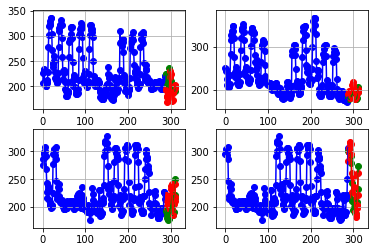

epoch = 0900, grad_step = 061268, tr_loss (epoch) = 0.592, te_loss (epoch) = 2.925
epoch = 0901, grad_step = 061336, tr_loss (epoch) = 0.607, te_loss (epoch) = 3.502
epoch = 0902, grad_step = 061404, tr_loss (epoch) = 0.605, te_loss (epoch) = 3.068
epoch = 0903, grad_step = 061472, tr_loss (epoch) = 0.624, te_loss (epoch) = 3.193
epoch = 0904, grad_step = 061540, tr_loss (epoch) = 0.617, te_loss (epoch) = 3.024
epoch = 0905, grad_step = 061608, tr_loss (epoch) = 0.648, te_loss (epoch) = 4.337
epoch = 0906, grad_step = 061676, tr_loss (epoch) = 0.673, te_loss (epoch) = 4.290
epoch = 0907, grad_step = 061744, tr_loss (epoch) = 0.686, te_loss (epoch) = 3.628
epoch = 0908, grad_step = 061812, tr_loss (epoch) = 0.621, te_loss (epoch) = 3.728
epoch = 0909, grad_step = 061880, tr_loss (epoch) = 0.593, te_loss (epoch) = 3.243


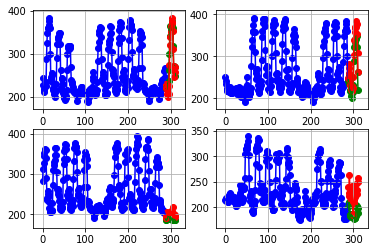

epoch = 0910, grad_step = 061948, tr_loss (epoch) = 0.557, te_loss (epoch) = 3.348
epoch = 0911, grad_step = 062016, tr_loss (epoch) = 0.557, te_loss (epoch) = 3.298
epoch = 0912, grad_step = 062084, tr_loss (epoch) = 0.532, te_loss (epoch) = 3.085
epoch = 0913, grad_step = 062152, tr_loss (epoch) = 0.514, te_loss (epoch) = 3.193
epoch = 0914, grad_step = 062220, tr_loss (epoch) = 0.500, te_loss (epoch) = 2.809
epoch = 0915, grad_step = 062288, tr_loss (epoch) = 0.498, te_loss (epoch) = 2.830
epoch = 0916, grad_step = 062356, tr_loss (epoch) = 0.517, te_loss (epoch) = 2.808
epoch = 0917, grad_step = 062424, tr_loss (epoch) = 0.521, te_loss (epoch) = 2.960
epoch = 0918, grad_step = 062492, tr_loss (epoch) = 0.535, te_loss (epoch) = 3.167
epoch = 0919, grad_step = 062560, tr_loss (epoch) = 0.577, te_loss (epoch) = 4.363


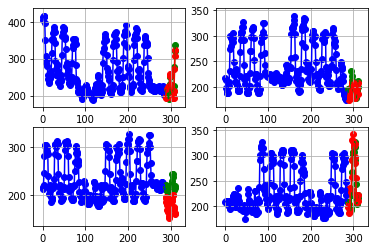

epoch = 0920, grad_step = 062628, tr_loss (epoch) = 0.622, te_loss (epoch) = 3.631
epoch = 0921, grad_step = 062696, tr_loss (epoch) = 0.631, te_loss (epoch) = 3.392
epoch = 0922, grad_step = 062764, tr_loss (epoch) = 0.657, te_loss (epoch) = 4.988
epoch = 0923, grad_step = 062832, tr_loss (epoch) = 0.770, te_loss (epoch) = 5.694
epoch = 0924, grad_step = 062900, tr_loss (epoch) = 0.826, te_loss (epoch) = 4.515
epoch = 0925, grad_step = 062968, tr_loss (epoch) = 0.852, te_loss (epoch) = 4.478
epoch = 0926, grad_step = 063036, tr_loss (epoch) = 0.731, te_loss (epoch) = 4.681
epoch = 0927, grad_step = 063104, tr_loss (epoch) = 0.637, te_loss (epoch) = 2.718
epoch = 0928, grad_step = 063172, tr_loss (epoch) = 0.593, te_loss (epoch) = 2.694
epoch = 0929, grad_step = 063240, tr_loss (epoch) = 0.573, te_loss (epoch) = 3.309


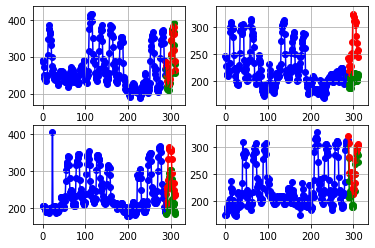

epoch = 0930, grad_step = 063308, tr_loss (epoch) = 0.522, te_loss (epoch) = 3.622
epoch = 0931, grad_step = 063376, tr_loss (epoch) = 0.558, te_loss (epoch) = 3.635
epoch = 0932, grad_step = 063444, tr_loss (epoch) = 0.551, te_loss (epoch) = 3.074
epoch = 0933, grad_step = 063512, tr_loss (epoch) = 0.519, te_loss (epoch) = 2.870
epoch = 0934, grad_step = 063580, tr_loss (epoch) = 0.500, te_loss (epoch) = 2.625
epoch = 0935, grad_step = 063648, tr_loss (epoch) = 0.492, te_loss (epoch) = 2.574
epoch = 0936, grad_step = 063716, tr_loss (epoch) = 0.493, te_loss (epoch) = 2.519
epoch = 0937, grad_step = 063784, tr_loss (epoch) = 0.511, te_loss (epoch) = 3.545
epoch = 0938, grad_step = 063852, tr_loss (epoch) = 0.559, te_loss (epoch) = 3.284
epoch = 0939, grad_step = 063920, tr_loss (epoch) = 0.569, te_loss (epoch) = 3.221


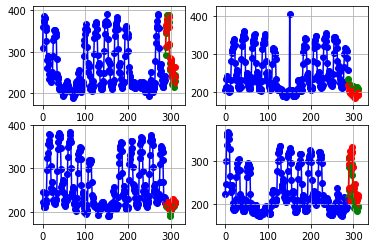

epoch = 0940, grad_step = 063988, tr_loss (epoch) = 0.560, te_loss (epoch) = 3.279
epoch = 0941, grad_step = 064056, tr_loss (epoch) = 0.579, te_loss (epoch) = 3.750
epoch = 0942, grad_step = 064124, tr_loss (epoch) = 0.594, te_loss (epoch) = 3.236
epoch = 0943, grad_step = 064192, tr_loss (epoch) = 0.551, te_loss (epoch) = 2.998
epoch = 0944, grad_step = 064260, tr_loss (epoch) = 0.541, te_loss (epoch) = 2.825
epoch = 0945, grad_step = 064328, tr_loss (epoch) = 0.533, te_loss (epoch) = 2.679
epoch = 0946, grad_step = 064396, tr_loss (epoch) = 0.526, te_loss (epoch) = 2.985
epoch = 0947, grad_step = 064464, tr_loss (epoch) = 0.528, te_loss (epoch) = 3.334
epoch = 0948, grad_step = 064532, tr_loss (epoch) = 0.551, te_loss (epoch) = 2.843
epoch = 0949, grad_step = 064600, tr_loss (epoch) = 0.511, te_loss (epoch) = 2.916


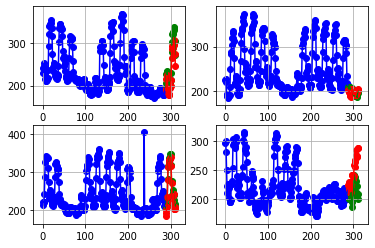

epoch = 0950, grad_step = 064668, tr_loss (epoch) = 0.518, te_loss (epoch) = 2.603
epoch = 0951, grad_step = 064736, tr_loss (epoch) = 0.505, te_loss (epoch) = 2.650
epoch = 0952, grad_step = 064804, tr_loss (epoch) = 0.493, te_loss (epoch) = 3.674
epoch = 0953, grad_step = 064872, tr_loss (epoch) = 0.516, te_loss (epoch) = 3.035
epoch = 0954, grad_step = 064940, tr_loss (epoch) = 0.499, te_loss (epoch) = 2.826
epoch = 0955, grad_step = 065008, tr_loss (epoch) = 0.506, te_loss (epoch) = 3.299
epoch = 0956, grad_step = 065076, tr_loss (epoch) = 0.503, te_loss (epoch) = 2.528
epoch = 0957, grad_step = 065144, tr_loss (epoch) = 0.518, te_loss (epoch) = 2.754
epoch = 0958, grad_step = 065212, tr_loss (epoch) = 0.530, te_loss (epoch) = 2.705
epoch = 0959, grad_step = 065280, tr_loss (epoch) = 0.561, te_loss (epoch) = 2.882


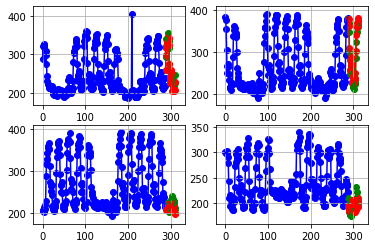

epoch = 0960, grad_step = 065348, tr_loss (epoch) = 0.528, te_loss (epoch) = 2.848
epoch = 0961, grad_step = 065416, tr_loss (epoch) = 0.584, te_loss (epoch) = 3.197
epoch = 0962, grad_step = 065484, tr_loss (epoch) = 0.577, te_loss (epoch) = 3.146
epoch = 0963, grad_step = 065552, tr_loss (epoch) = 0.667, te_loss (epoch) = 2.496
epoch = 0964, grad_step = 065620, tr_loss (epoch) = 0.816, te_loss (epoch) = 9.278
epoch = 0965, grad_step = 065688, tr_loss (epoch) = 1.636, te_loss (epoch) = 4.917
epoch = 0966, grad_step = 065756, tr_loss (epoch) = 1.402, te_loss (epoch) = 2.816
epoch = 0967, grad_step = 065824, tr_loss (epoch) = 1.517, te_loss (epoch) = 2.504
epoch = 0968, grad_step = 065892, tr_loss (epoch) = 1.004, te_loss (epoch) = 2.342
epoch = 0969, grad_step = 065960, tr_loss (epoch) = 0.731, te_loss (epoch) = 2.389


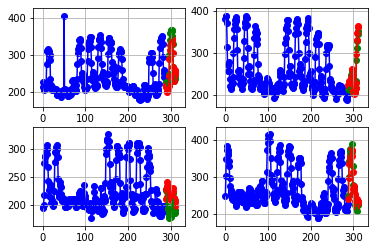

epoch = 0970, grad_step = 066028, tr_loss (epoch) = 0.620, te_loss (epoch) = 2.377
epoch = 0971, grad_step = 066096, tr_loss (epoch) = 0.551, te_loss (epoch) = 3.113
epoch = 0972, grad_step = 066164, tr_loss (epoch) = 0.534, te_loss (epoch) = 3.900
epoch = 0973, grad_step = 066232, tr_loss (epoch) = 0.542, te_loss (epoch) = 3.224
epoch = 0974, grad_step = 066300, tr_loss (epoch) = 0.512, te_loss (epoch) = 2.626
epoch = 0975, grad_step = 066368, tr_loss (epoch) = 0.494, te_loss (epoch) = 2.508
epoch = 0976, grad_step = 066436, tr_loss (epoch) = 0.479, te_loss (epoch) = 2.988
epoch = 0977, grad_step = 066504, tr_loss (epoch) = 0.486, te_loss (epoch) = 3.112
epoch = 0978, grad_step = 066572, tr_loss (epoch) = 0.498, te_loss (epoch) = 2.769
epoch = 0979, grad_step = 066640, tr_loss (epoch) = 0.485, te_loss (epoch) = 2.609


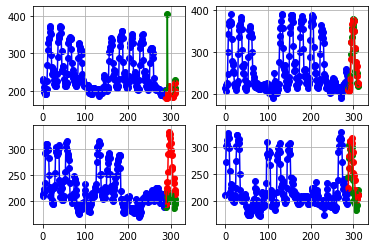

epoch = 0980, grad_step = 066708, tr_loss (epoch) = 0.497, te_loss (epoch) = 2.590
epoch = 0981, grad_step = 066776, tr_loss (epoch) = 0.495, te_loss (epoch) = 2.540
epoch = 0982, grad_step = 066844, tr_loss (epoch) = 0.481, te_loss (epoch) = 3.636
epoch = 0983, grad_step = 066912, tr_loss (epoch) = 0.507, te_loss (epoch) = 3.935
epoch = 0984, grad_step = 066980, tr_loss (epoch) = 0.528, te_loss (epoch) = 3.132
epoch = 0985, grad_step = 067048, tr_loss (epoch) = 0.512, te_loss (epoch) = 2.749
epoch = 0986, grad_step = 067116, tr_loss (epoch) = 0.498, te_loss (epoch) = 2.540
epoch = 0987, grad_step = 067184, tr_loss (epoch) = 0.484, te_loss (epoch) = 2.479
epoch = 0988, grad_step = 067252, tr_loss (epoch) = 0.473, te_loss (epoch) = 2.749
epoch = 0989, grad_step = 067320, tr_loss (epoch) = 0.473, te_loss (epoch) = 2.646


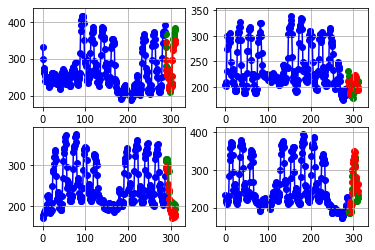

epoch = 0990, grad_step = 067388, tr_loss (epoch) = 0.466, te_loss (epoch) = 2.584
epoch = 0991, grad_step = 067456, tr_loss (epoch) = 0.467, te_loss (epoch) = 2.884
epoch = 0992, grad_step = 067524, tr_loss (epoch) = 0.487, te_loss (epoch) = 2.917
epoch = 0993, grad_step = 067592, tr_loss (epoch) = 0.494, te_loss (epoch) = 3.018
epoch = 0994, grad_step = 067660, tr_loss (epoch) = 0.507, te_loss (epoch) = 3.958
epoch = 0995, grad_step = 067728, tr_loss (epoch) = 0.527, te_loss (epoch) = 3.867
epoch = 0996, grad_step = 067796, tr_loss (epoch) = 0.518, te_loss (epoch) = 3.288
epoch = 0997, grad_step = 067864, tr_loss (epoch) = 0.524, te_loss (epoch) = 2.965
epoch = 0998, grad_step = 067932, tr_loss (epoch) = 0.562, te_loss (epoch) = 2.817
epoch = 0999, grad_step = 068000, tr_loss (epoch) = 0.517, te_loss (epoch) = 2.610


In [414]:
grad_step=0
trloss = []
teloss = []
for epoch in range(1000):
    net.train()
    train_loss=[]
    for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
        grad_step += 1
        optimiser.zero_grad()
        _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
        loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
        train_loss.append(loss.item())
        loss.backward()
        optimiser.step()
    train_loss = np.mean(train_loss)
    net.eval()
    _, forecast = net(torch.tensor(x_test, dtype=torch.float))
    test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
    p = forecast.detach().numpy()
    if epoch % 10 == 0:
            subplots = [221, 222, 223, 224]
            plt.figure(1)
            for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
                ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
                plt.subplot(subplots[plot_id])
                plt.grid()
                plot_scatter(range(0, backcast_length), xx, color='b')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
            plt.show()
    with torch.no_grad():
        save(net, optimiser, grad_step)
    trloss.append(1000*train_loss)
    teloss.append(1000*test_loss)
    print(f'epoch = {str(epoch).zfill(4)}, '
        f'grad_step = {str(grad_step).zfill(6)}, '
        f'tr_loss (epoch) = {1000 * train_loss:.3f}, '
        f'te_loss (epoch) = {1000 * test_loss:.3f}')



In [59]:
p[1]


NameError: name 'p' is not defined

In [456]:
for i in teloss:
    print(teloss)

[[-6.         -6.         -6.         -6.         -6.         -6.
  -6.         -6.         -6.         -6.         -6.         -6.
  -6.         -6.         -6.         -6.         -6.         -6.
  -6.         -6.         -6.         -6.         -6.         -6.
  -6.         -6.         -6.         -6.         -6.         -6.        ]
 [-5.5862069  -5.5862069  -5.5862069  -5.5862069  -5.5862069  -5.5862069
  -5.5862069  -5.5862069  -5.5862069  -5.5862069  -5.5862069  -5.5862069
  -5.5862069  -5.5862069  -5.5862069  -5.5862069  -5.5862069  -5.5862069
  -5.5862069  -5.5862069  -5.5862069  -5.5862069  -5.5862069  -5.5862069
  -5.5862069  -5.5862069  -5.5862069  -5.5862069  -5.5862069  -5.5862069 ]
 [-5.17241379 -5.17241379 -5.17241379 -5.17241379 -5.17241379 -5.17241379
  -5.17241379 -5.17241379 -5.17241379 -5.17241379 -5.17241379 -5.17241379
  -5.17241379 -5.17241379 -5.17241379 -5.17241379 -5.17241379 -5.17241379
  -5.17241379 -5.17241379 -5.17241379 -5.17241379 -5.17241379 -5.1724137

[[-6.         -6.         -6.         -6.         -6.         -6.
  -6.         -6.         -6.         -6.         -6.         -6.
  -6.         -6.         -6.         -6.         -6.         -6.
  -6.         -6.         -6.         -6.         -6.         -6.
  -6.         -6.         -6.         -6.         -6.         -6.        ]
 [-5.5862069  -5.5862069  -5.5862069  -5.5862069  -5.5862069  -5.5862069
  -5.5862069  -5.5862069  -5.5862069  -5.5862069  -5.5862069  -5.5862069
  -5.5862069  -5.5862069  -5.5862069  -5.5862069  -5.5862069  -5.5862069
  -5.5862069  -5.5862069  -5.5862069  -5.5862069  -5.5862069  -5.5862069
  -5.5862069  -5.5862069  -5.5862069  -5.5862069  -5.5862069  -5.5862069 ]
 [-5.17241379 -5.17241379 -5.17241379 -5.17241379 -5.17241379 -5.17241379
  -5.17241379 -5.17241379 -5.17241379 -5.17241379 -5.17241379 -5.17241379
  -5.17241379 -5.17241379 -5.17241379 -5.17241379 -5.17241379 -5.17241379
  -5.17241379 -5.17241379 -5.17241379 -5.17241379 -5.17241379 -5.1724137

ValueError: Input passed into argument "'x'"is not 1-dimensional.

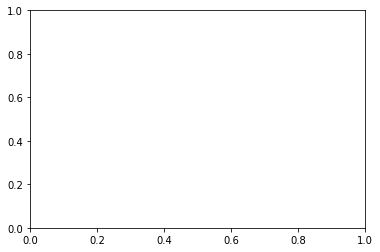

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (100,) and requested shape (30,)

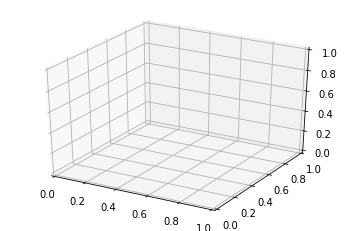

In [444]:

# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axes
z = np.linspace(0, 1, 100)
x = trloss
y = teloss
 
# plotting
ax.plot3D(x, y, z, 'green')
ax.set_title('3D line plot geeks for geeks')
plt.show()